# **A Data Driven Analysis on Football Players Under Different Managers Using Statistical and Machine Learning Models**

## **Importing Dataset & Libraries**


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler, PowerTransformer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

# Load all datasets
df_tm = pd.read_excel(r'C:\Users\Acer\cp_env\Analysis\team.xlsx')
df_mg = pd.read_excel(r'C:\Users\Acer\cp_env\Analysis\manager.xlsx')
df_mf = pd.read_excel(r'C:\Users\Acer\cp_env\Analysis\manager_formation.xlsx')
df_pl = pd.read_excel(r'C:\Users\Acer\cp_env\Analysis\player.xlsx')
df_psd = pd.read_csv(r'C:\Users\Acer\cp_env\Analysis\player_stat.csv')

df_ps = df_psd.copy()



In [43]:
# Convert Date to datetime
df_ps['Date'] = pd.to_datetime(df_ps['Date'])
from sklearn.preprocessing import LabelEncoder
# Encode binary columns
df_ps['Start_encoded'] = df_ps['Start'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)
df_ps['CrdY_flag'] = (df_ps['CrdY'] > 0).astype(int)
df_ps['CrdR_flag'] = (df_ps['CrdR'] > 0).astype(int)
outcome_encoder = LabelEncoder()
df_ps['Outcome_encoded'] = outcome_encoder.fit_transform(df_ps['Outcome'])
df_ps = pd.get_dummies(df_ps, columns=['Venue'], prefix='Venue', dtype=int)

# Bin penalties
def create_penalty_bins(col):
    max_val = df_ps[col].max()
    if max_val <= 1:
        bins = [-1, 0, max_val]
        labels = ['0', '1']
    else:
        bins = [-1, 0, 1, max_val]
        labels = ['0', '1', '2+']
    return pd.cut(df_ps[col], bins=bins, labels=labels, duplicates='drop')

df_ps['PK_bin'] = create_penalty_bins('PK')
df_ps['PKatt_bin'] = create_penalty_bins('PKatt')


In [44]:
cols_to_drop = ['Squad', 'Opponent', 'Round', 'Day', 'Score', 'Start', 'CrdY', 'CrdR', 'PK', 'PKatt']
df_ps = df_ps.drop([col for col in cols_to_drop if col in df_ps.columns], axis=1)
# Calculate per90 stats
stats_cols = ['Gls', 'Ast', 'Sh', 'SoT', 'Touches', 'Tkl', 'Int', 'Blocks', 
              'xG', 'npxG', 'xAG', 'SCA', 'GCA', 'Passes Cmp', 'Passes Att', 
              'Passes Cmp%', 'PrgP', 'Carries', 'Carries PrgC', 'Take-Ons Att', 
              'Take-Ons Succ']

for col in stats_cols:
    df_ps[col + '_per90'] = (df_ps[col] / df_ps['Min']) * 90

# Drop original stats
df_ps = df_ps.drop(stats_cols, axis=1, errors='ignore')

**Checking the Skewness of the Numeric Data**

In [45]:
# List of per90 columns
per90_cols = [
    'Gls_per90', 'Ast_per90', 'Sh_per90',
    'SoT_per90','Touches_per90', 'Tkl_per90',
    'Int_per90', 'Blocks_per90', 'xG_per90', 'npxG_per90', 'xAG_per90',
    'SCA_per90', 'GCA_per90', 'Passes Cmp_per90', 'Passes Att_per90',
    'Passes Cmp%_per90', 'PrgP_per90', 'Carries_per90',
    'Carries PrgC_per90', 'Take-Ons Att_per90', 'Take-Ons Succ_per90'
]

# Calculate skewness for each column
skewness_values = df_ps[per90_cols].skew()

skewness_sorted = skewness_values.abs().sort_values(ascending=False)
print(skewness_sorted)



Gls_per90              24.074539
Blocks_per90           22.735992
Ast_per90              15.989901
Passes Cmp%_per90      12.545433
GCA_per90              12.219045
Take-Ons Att_per90     11.528746
SoT_per90              11.023236
npxG_per90              9.348726
Carries PrgC_per90      9.139532
xG_per90                7.734629
xAG_per90               7.359026
Touches_per90           6.110648
Tkl_per90               4.649335
Carries_per90           4.499049
Take-Ons Succ_per90     4.397581
Sh_per90                4.366298
Int_per90               4.143504
PrgP_per90              3.970394
SCA_per90               2.743774
Passes Att_per90        1.962632
Passes Cmp_per90        1.686044
dtype: float64


**Potting the Skewness**

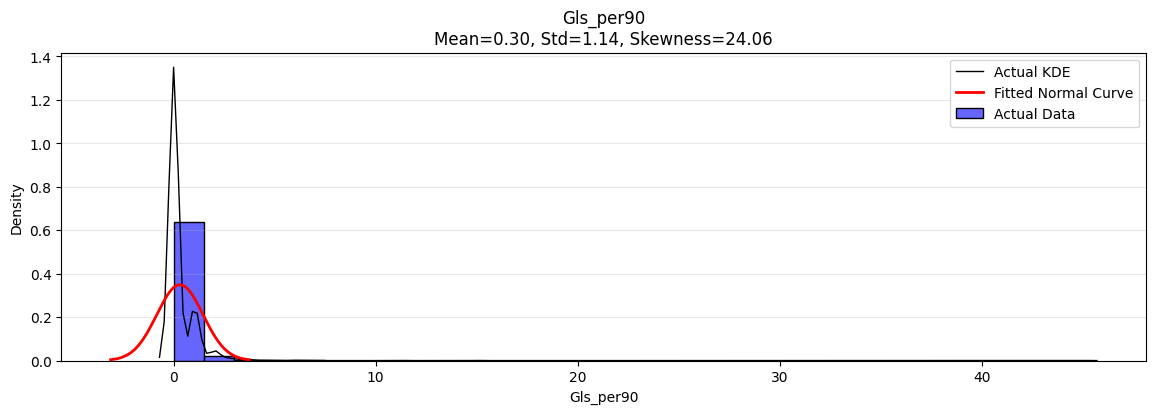

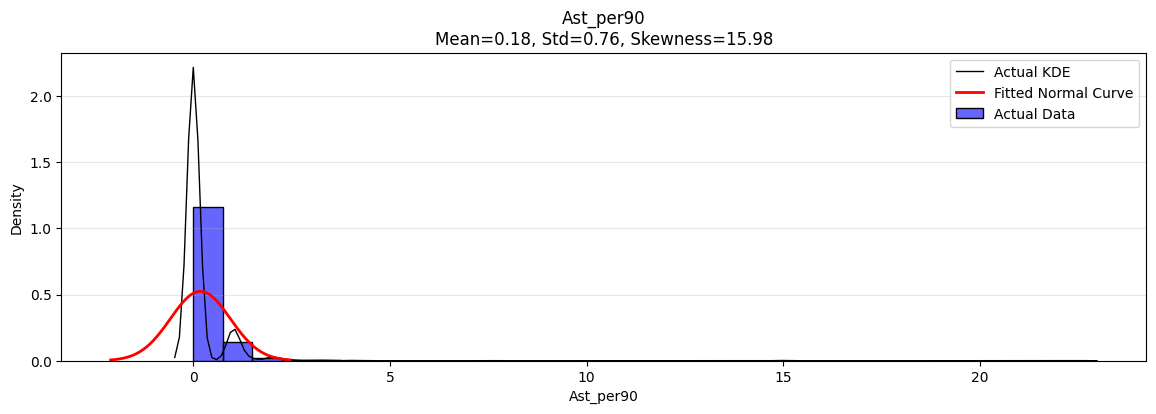

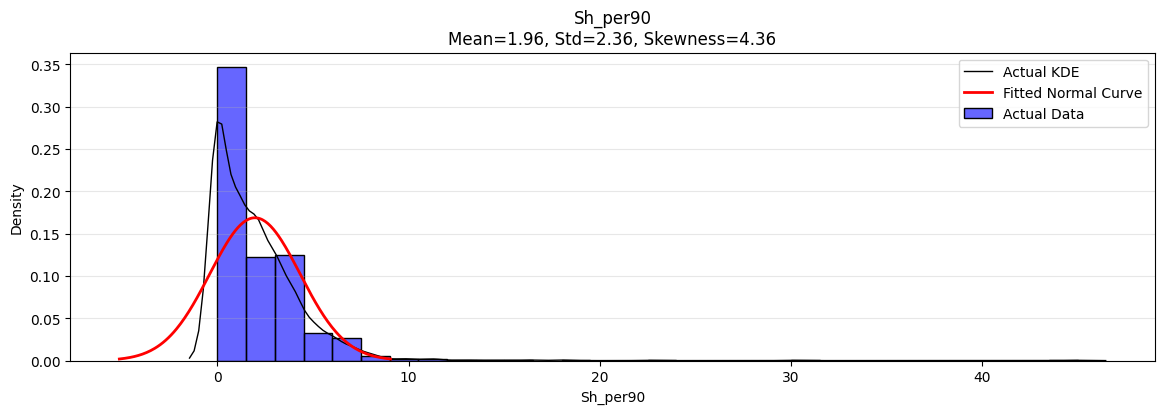

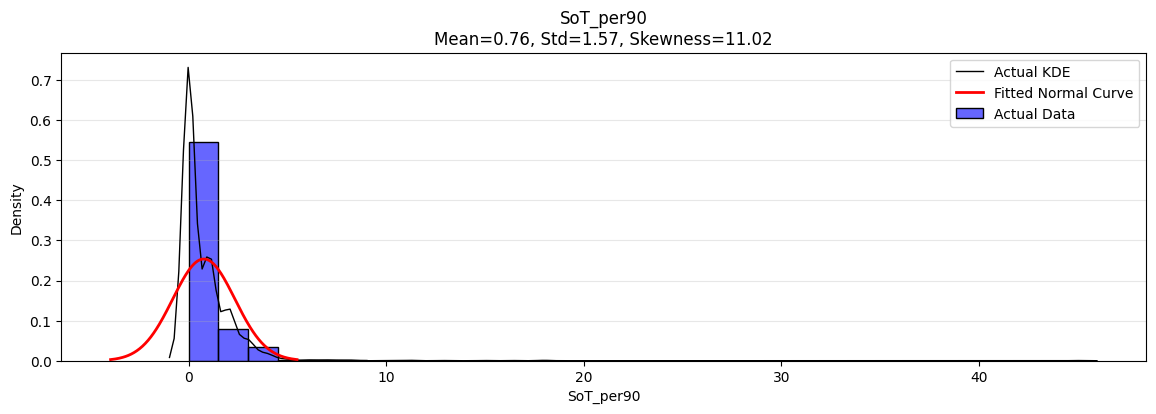

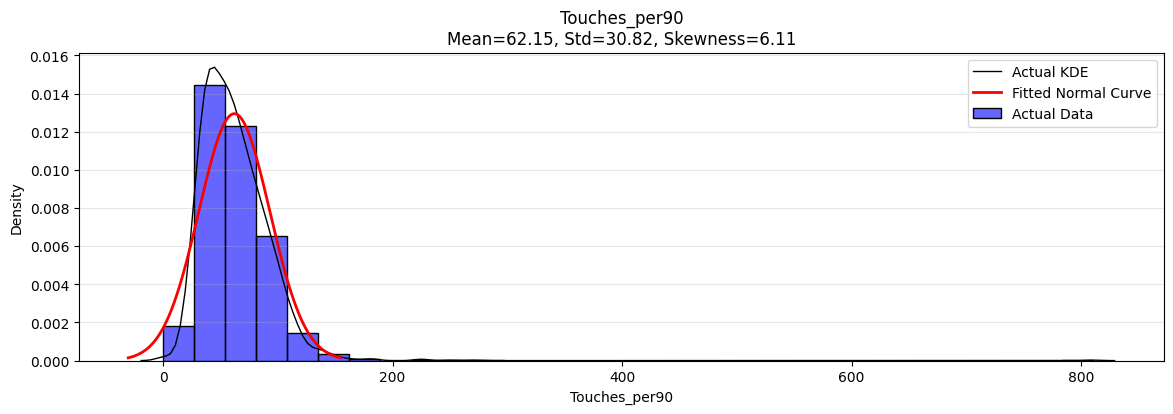

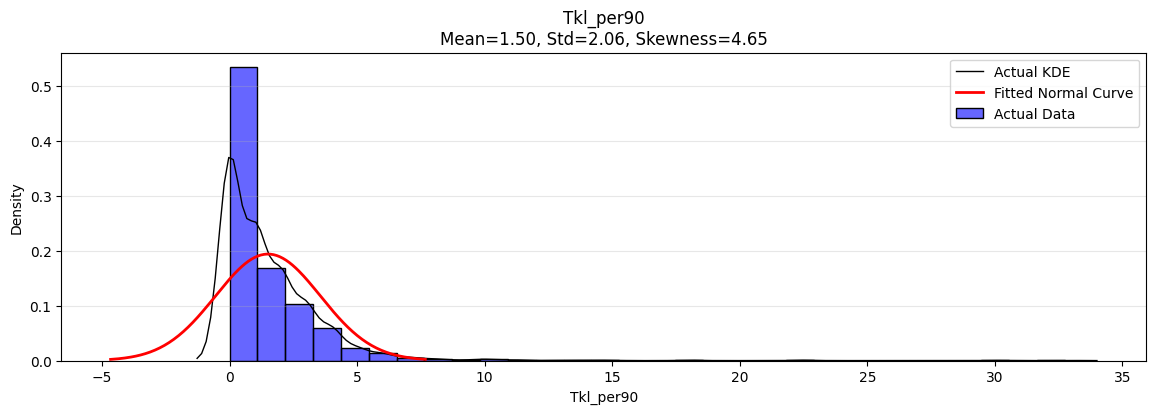

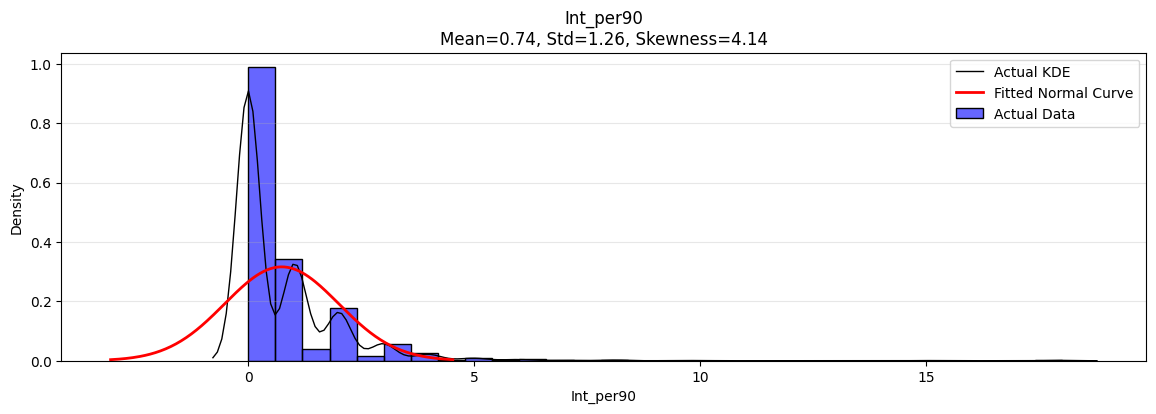

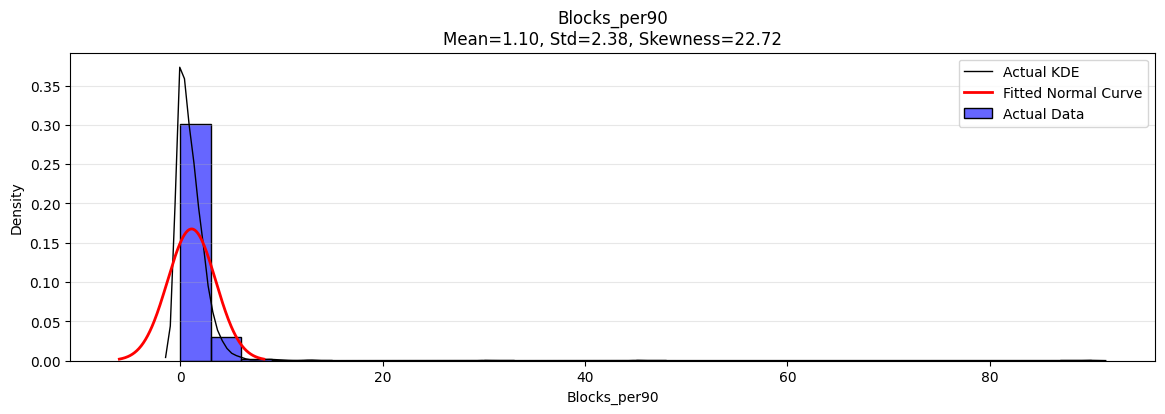

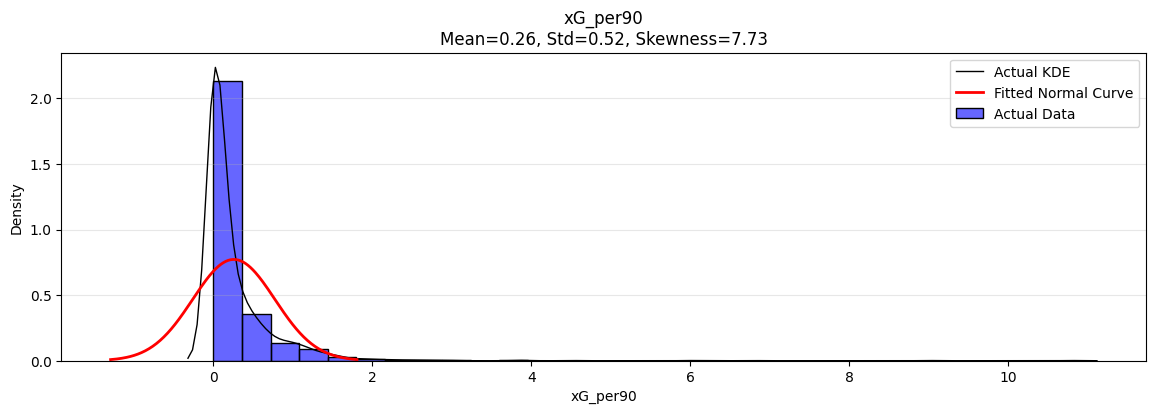

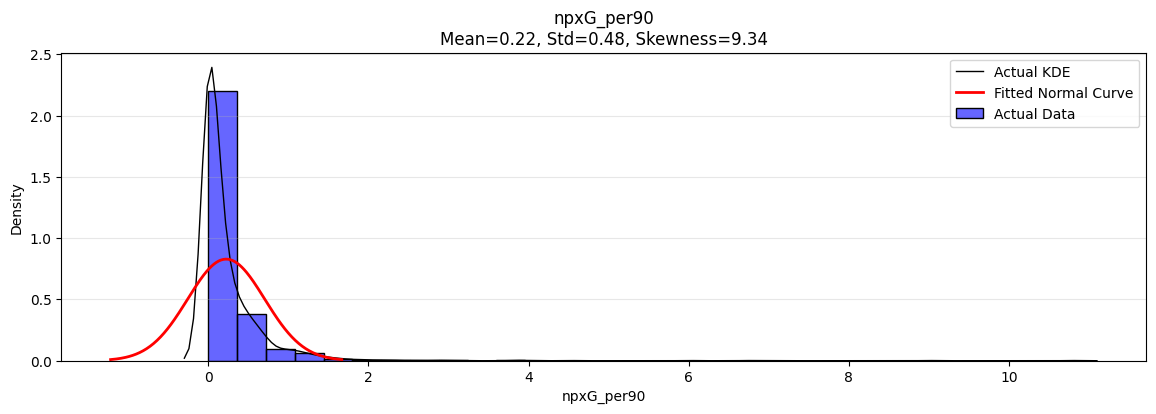

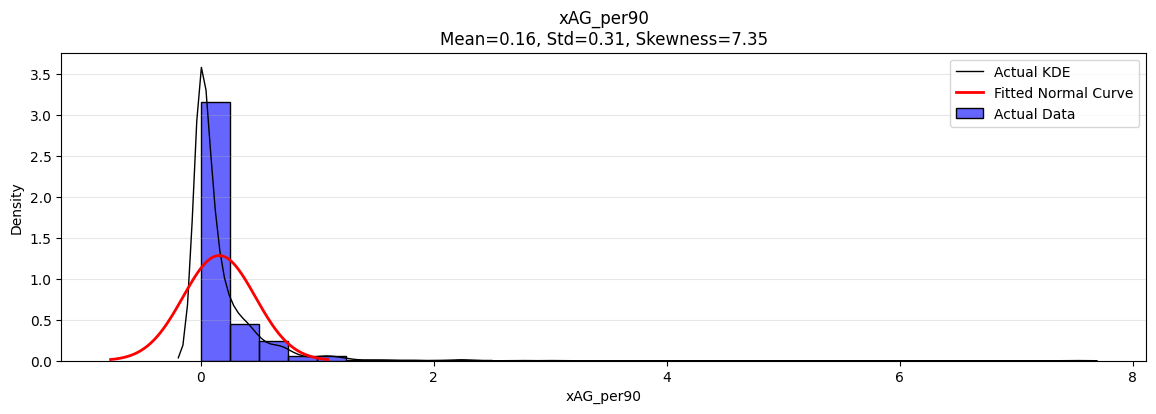

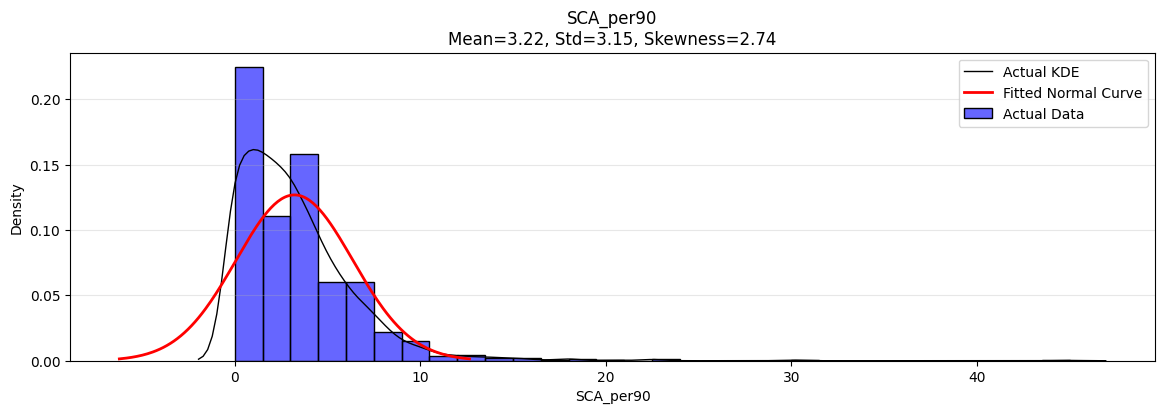

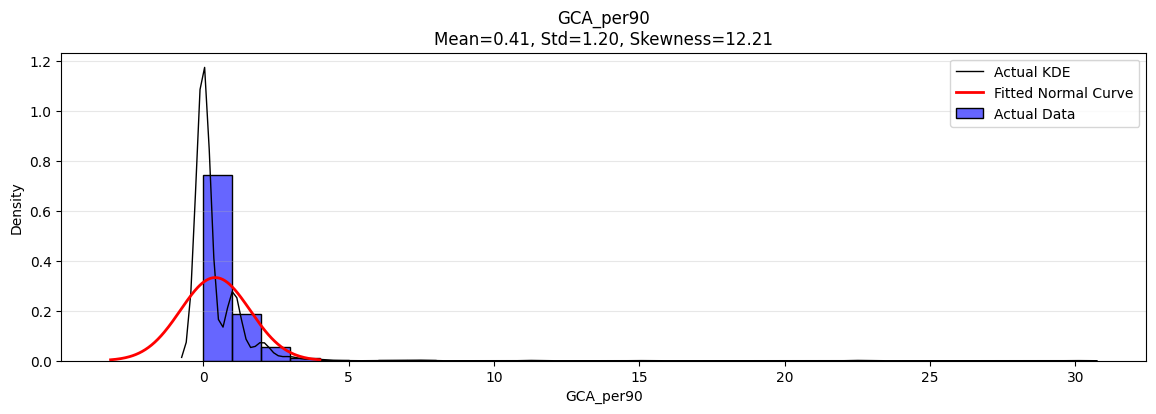

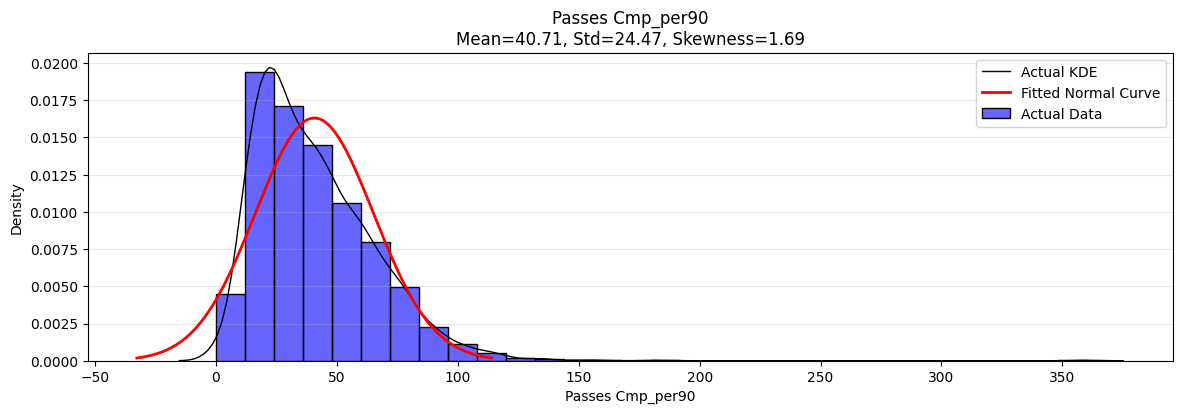

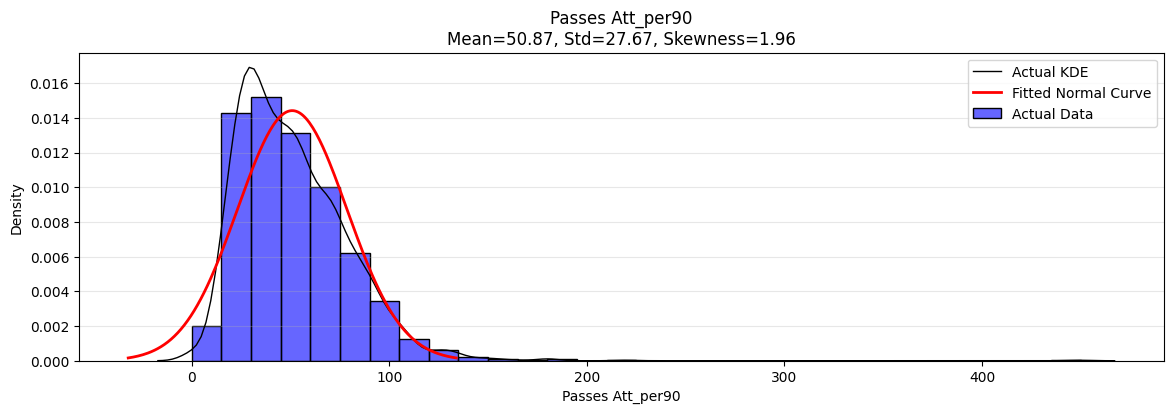

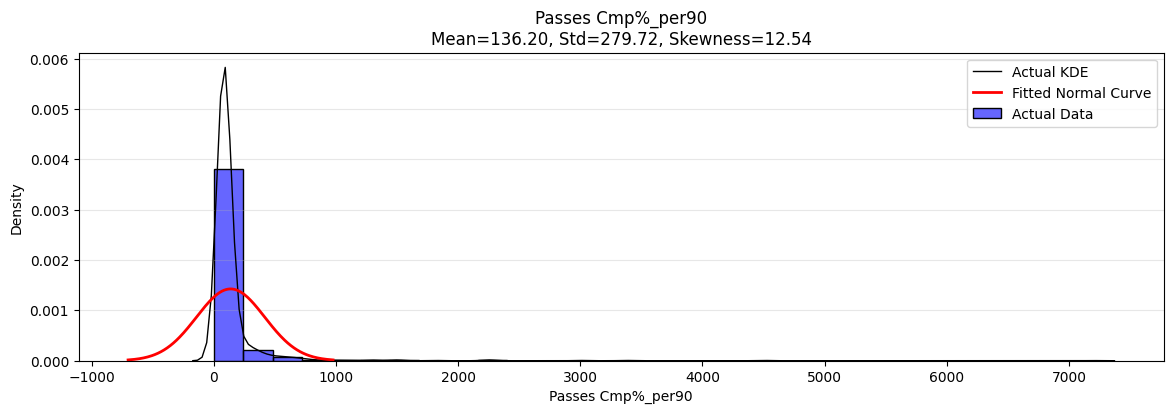

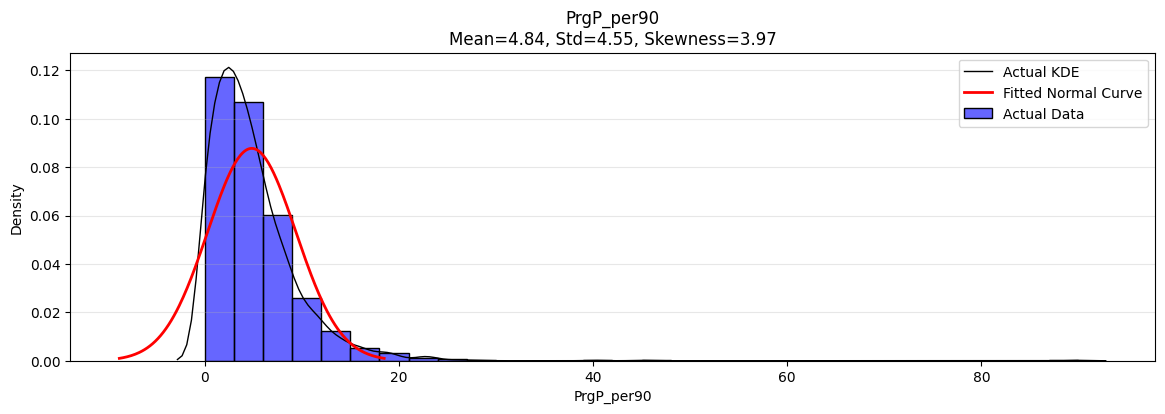

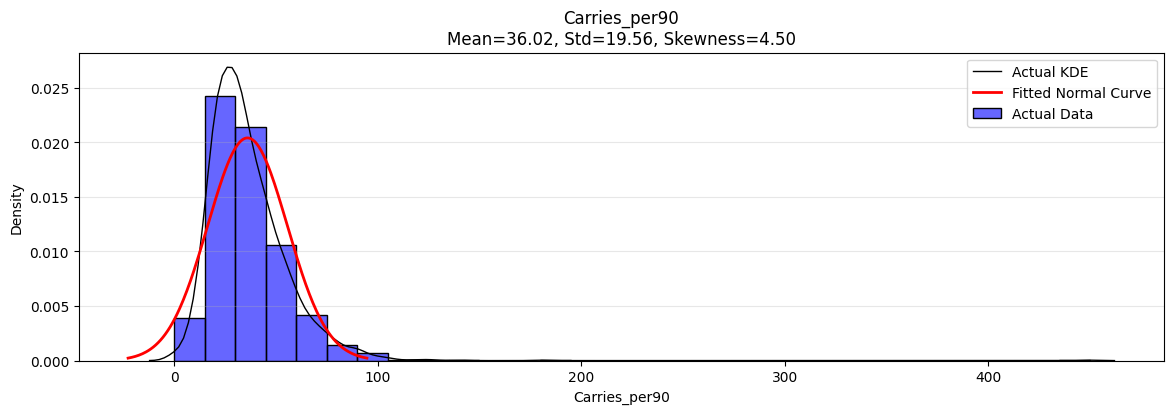

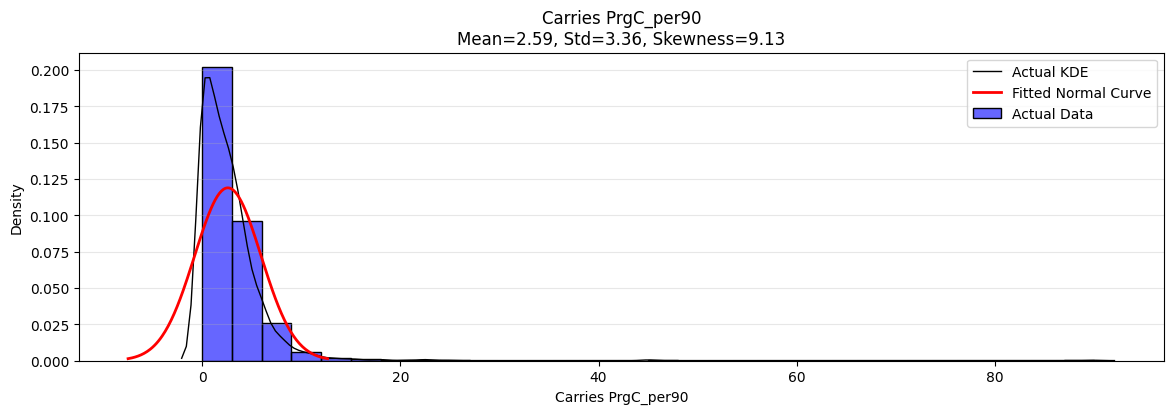

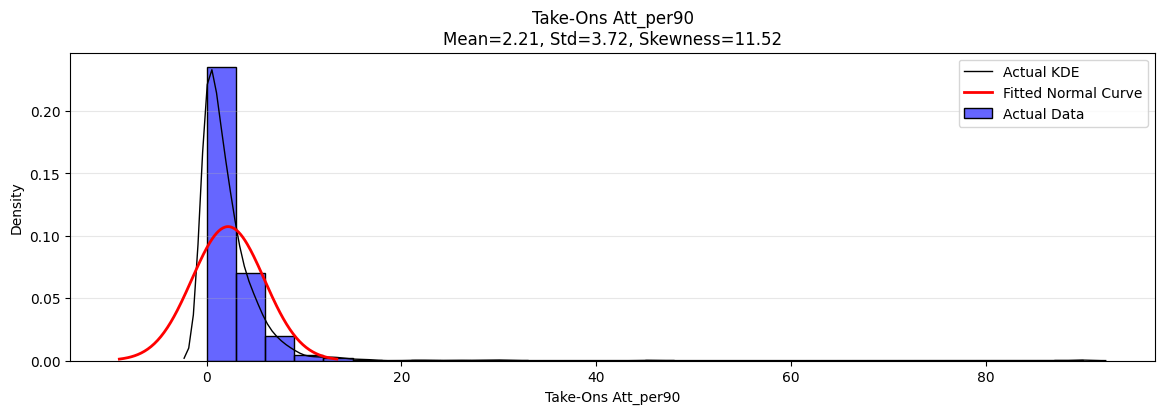

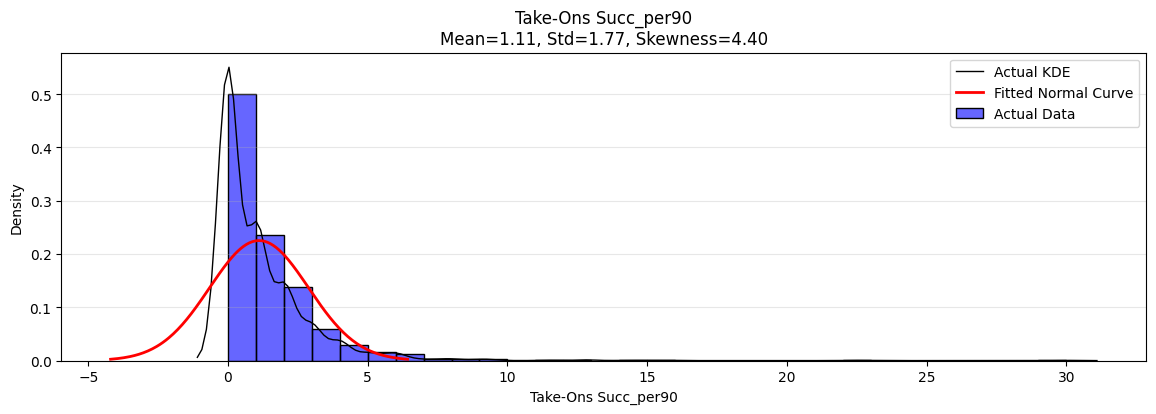

In [46]:
cols = [
    'Gls_per90', 'Ast_per90',  'Sh_per90',
    'SoT_per90', 'Touches_per90', 'Tkl_per90',
    'Int_per90', 'Blocks_per90', 'xG_per90', 'npxG_per90', 'xAG_per90',
    'SCA_per90', 'GCA_per90', 'Passes Cmp_per90', 'Passes Att_per90',
    'Passes Cmp%_per90', 'PrgP_per90', 'Carries_per90',
    'Carries PrgC_per90', 'Take-Ons Att_per90', 'Take-Ons Succ_per90'
]

for col in cols:
    data = df_ps[col].dropna()

    # Calculate skewness
    skew_val = skew(data)

    # Fit normal distribution
    mu, std = norm.fit(data)

    # Create histogram
    plt.figure(figsize=(14, 4))
    sns.histplot(
        data, stat="density", bins=30,
        color='blue', edgecolor='black', alpha=0.6,
        label='Actual Data'
    )

    # KDE line (actual distribution)
    sns.kdeplot(data, color='black', linewidth=1, label='Actual KDE')

    # Fitted normal curve
    x = np.linspace(mu - 3*std, mu + 3*std, 200)
    plt.plot(x, norm.pdf(x, mu, std), color='red', linewidth=2, label='Fitted Normal Curve')

    # Labels and title
    plt.title(f"{col}\nMean={mu:.2f}, Std={std:.2f}, Skewness={skew_val:.2f}", fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.show()


**Using Transformation to reduce the Skewness of the data**

In [47]:
# Columns needing transformation
cols_special = ['Gls_per90', 'Ast_per90', 'GCA_per90', 'Passes Cmp%_per90']
cols_to_transform = [col for col in df_ps.columns if col.endswith('_per90') and col not in cols_special]

# Apply Yeo-Johnson to special cols
pt = PowerTransformer(method='yeo-johnson')
for col in cols_special:
    df_ps[col + '_T'] = pt.fit_transform(df_ps[[col]])

# Apply cube root to others
for col in cols_to_transform:
    df_ps[col + '_T'] = np.cbrt(df_ps[col])

**Plotting the Tranformed data**

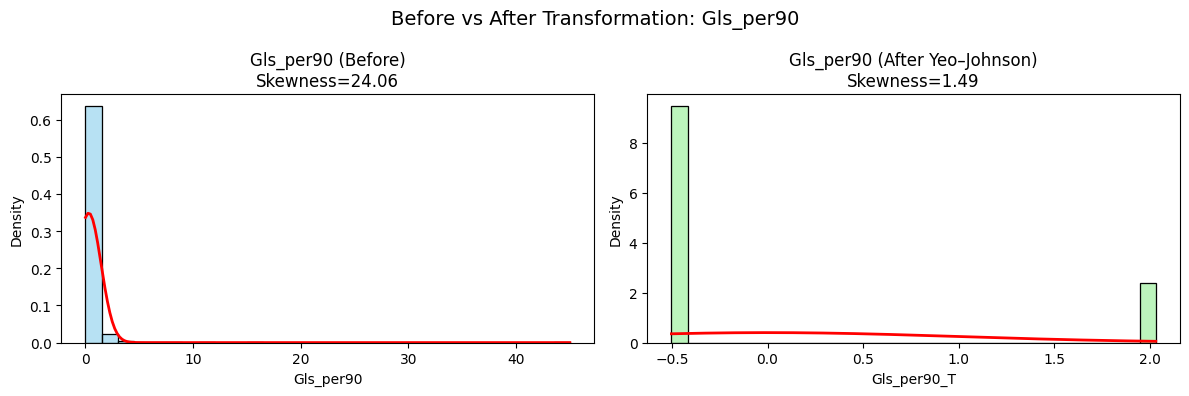

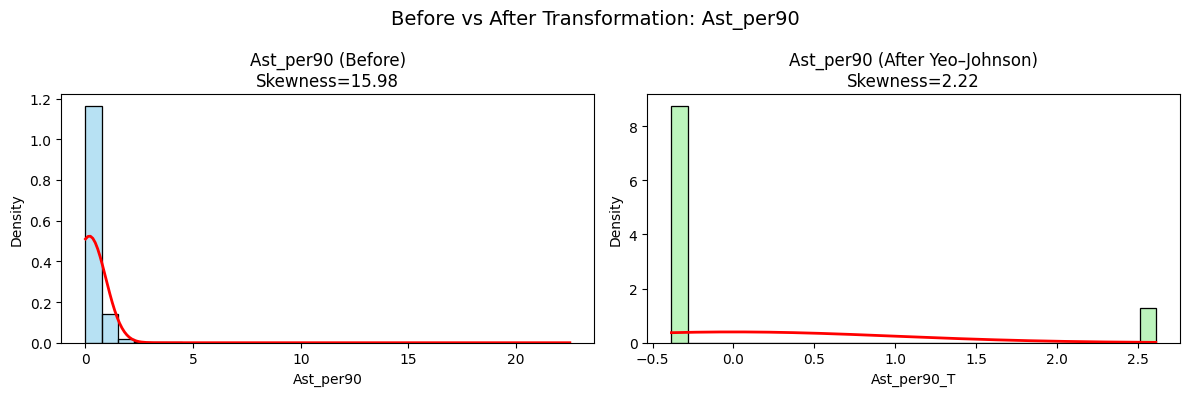

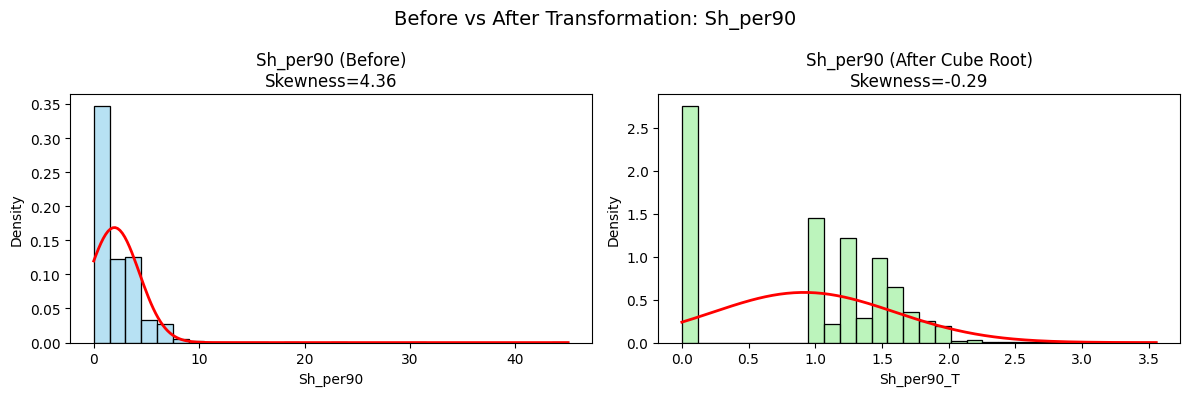

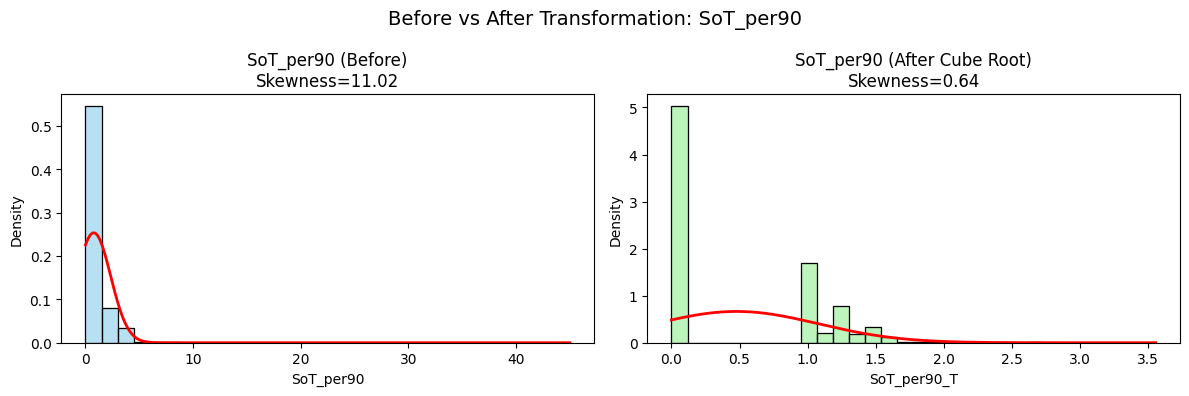

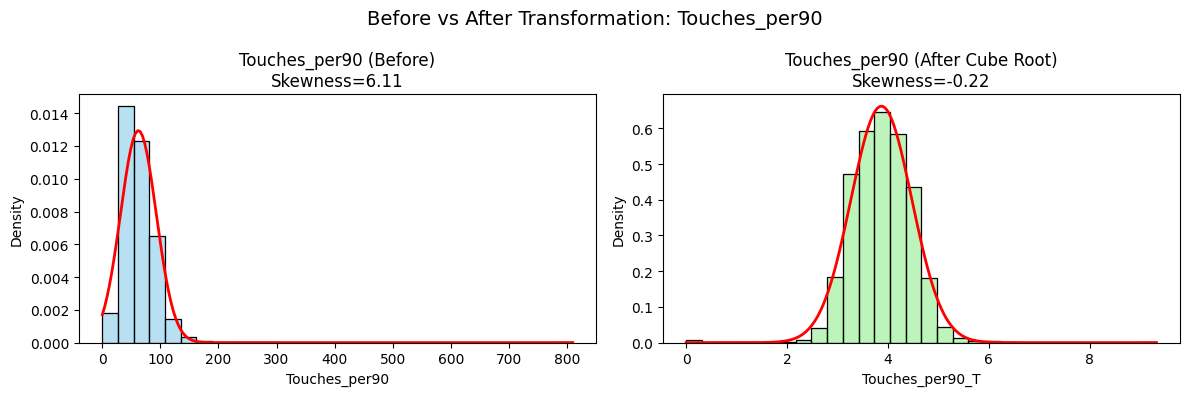

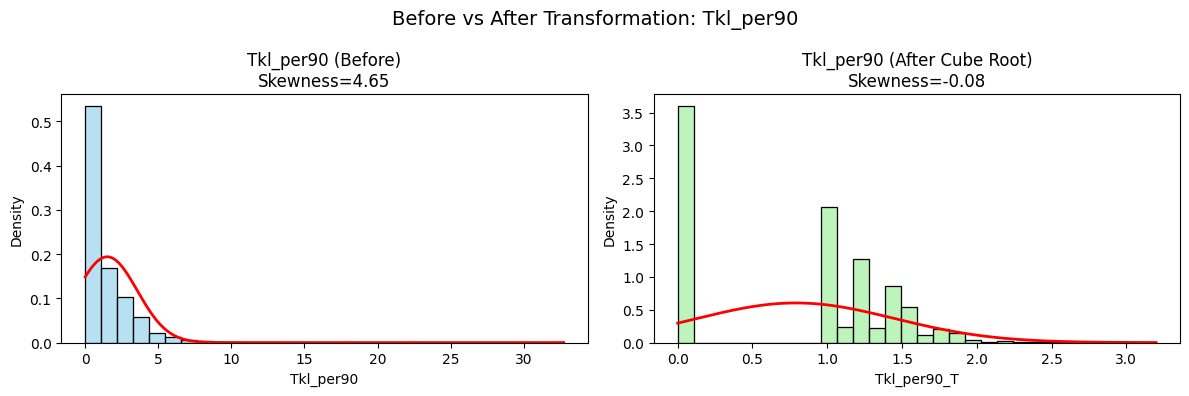

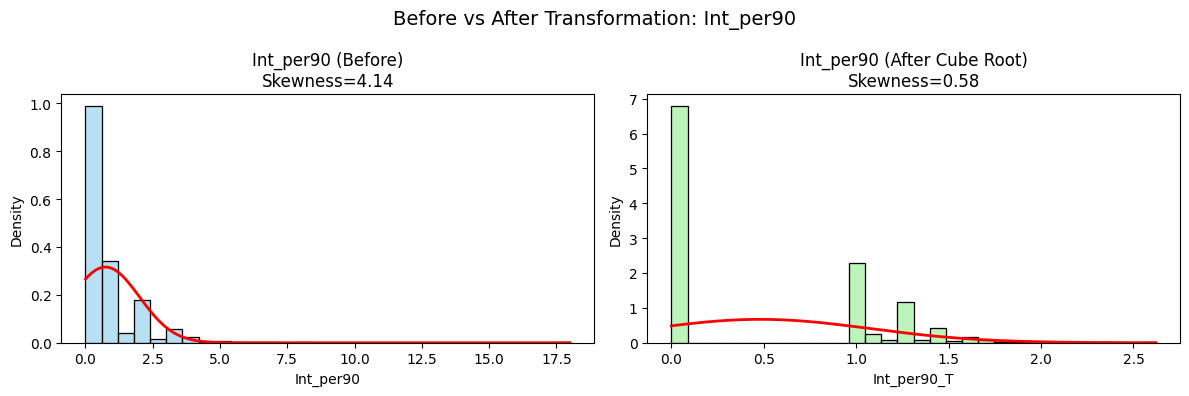

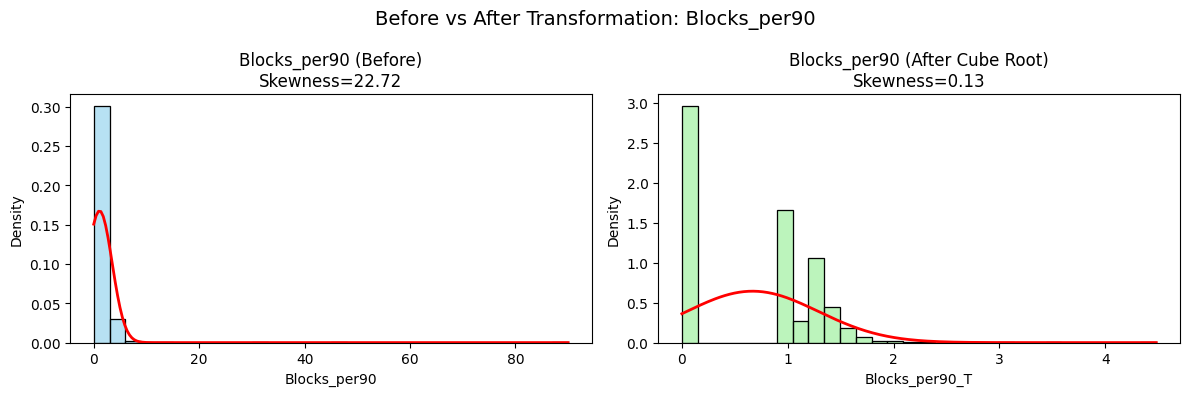

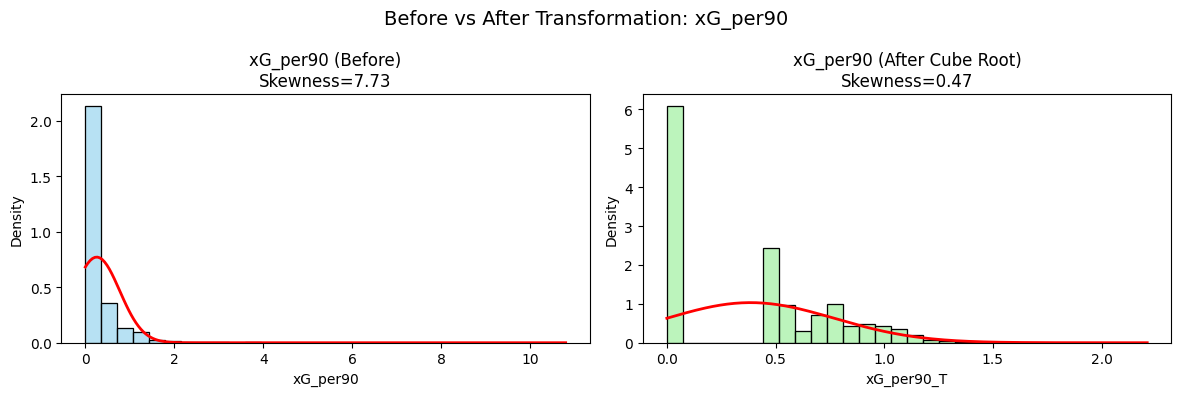

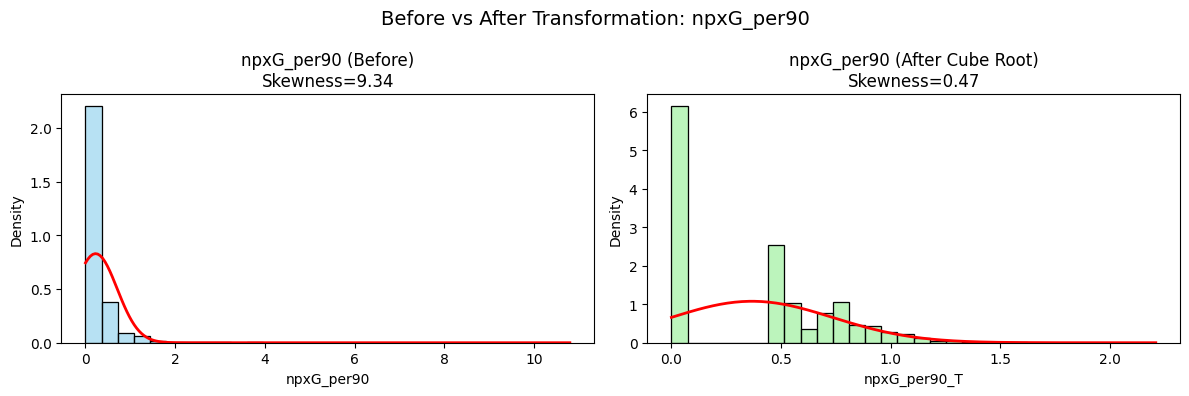

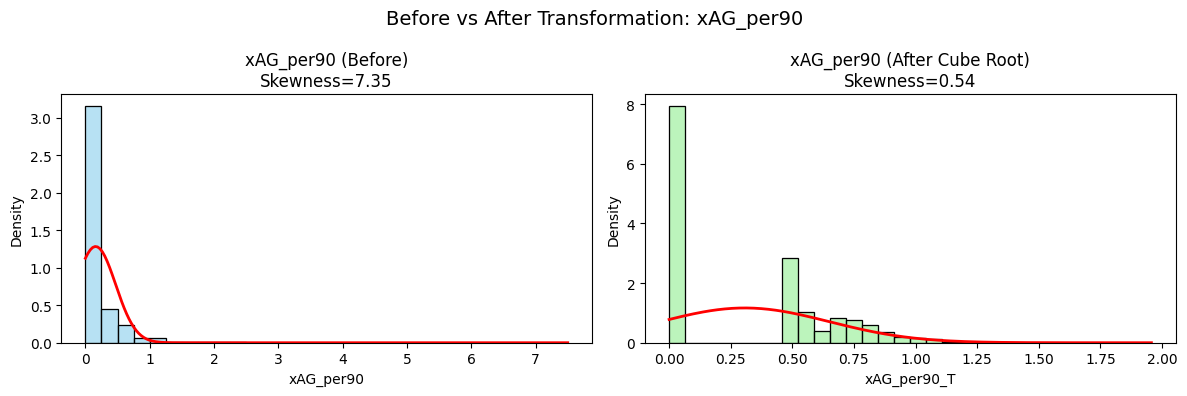

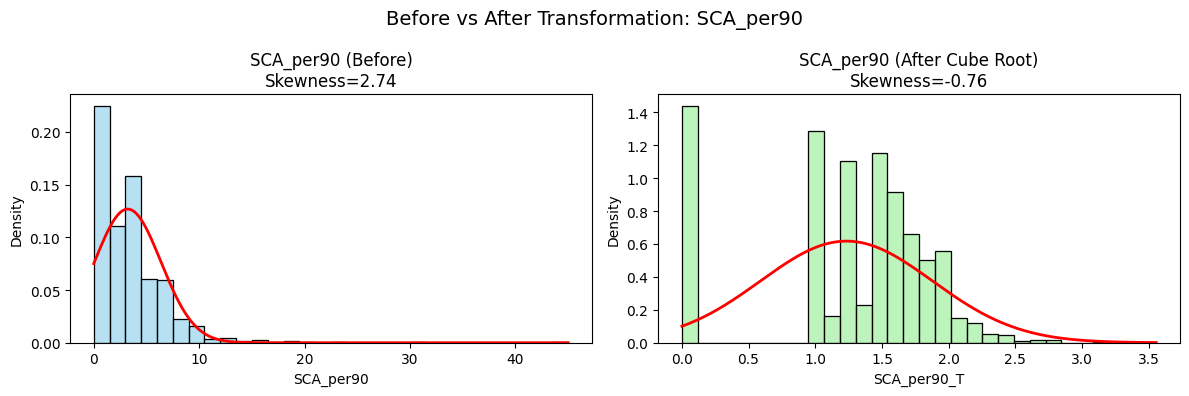

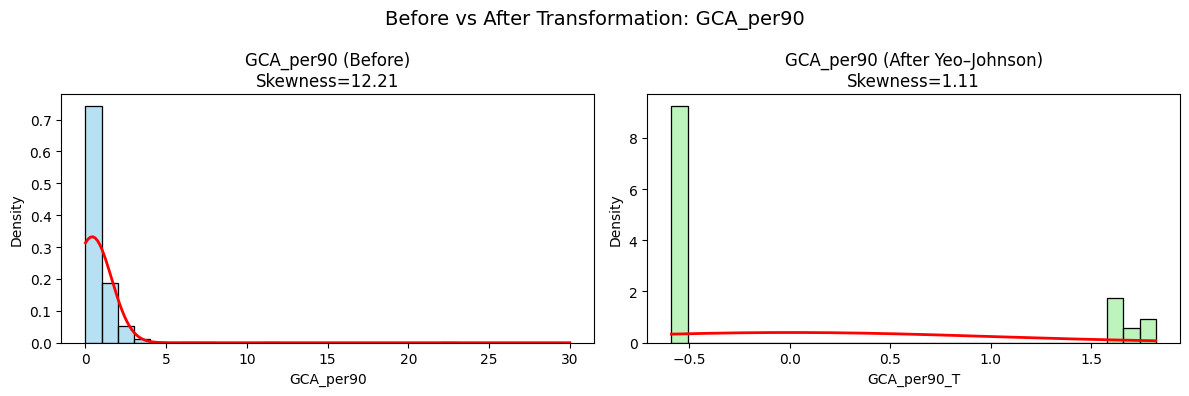

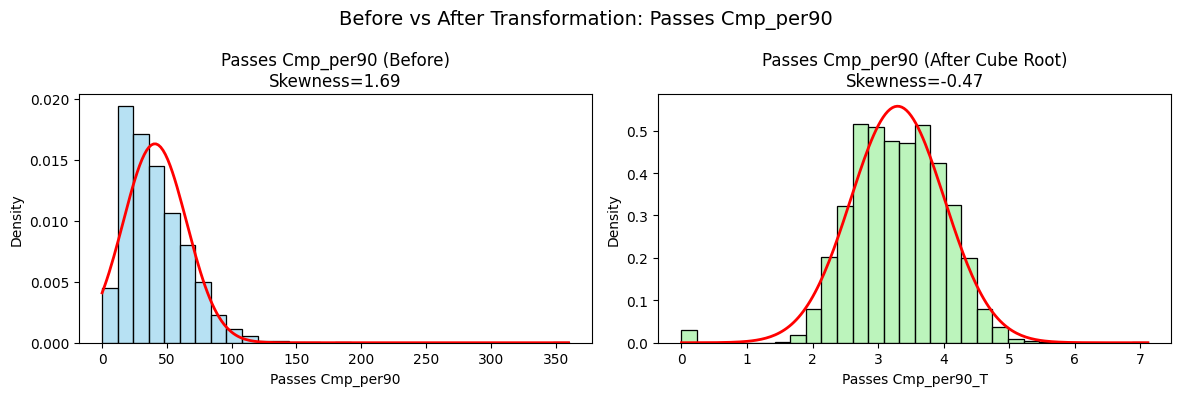

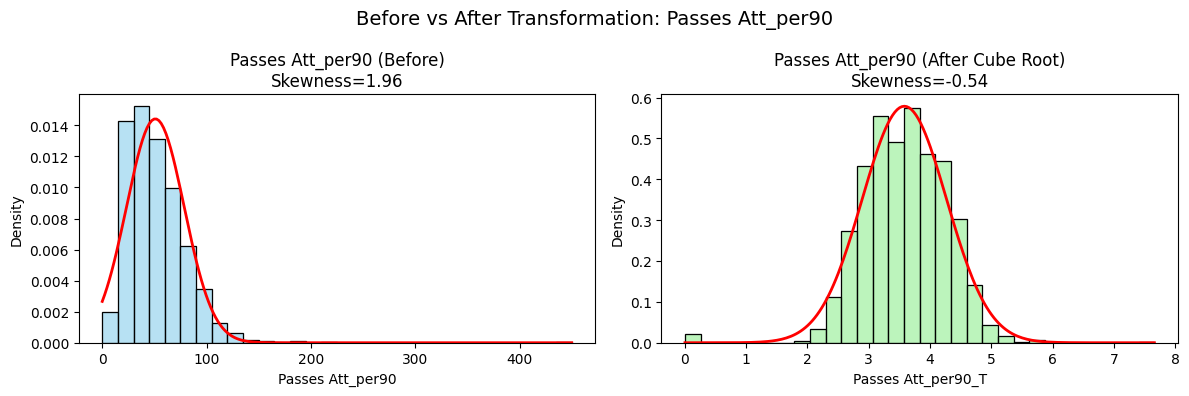

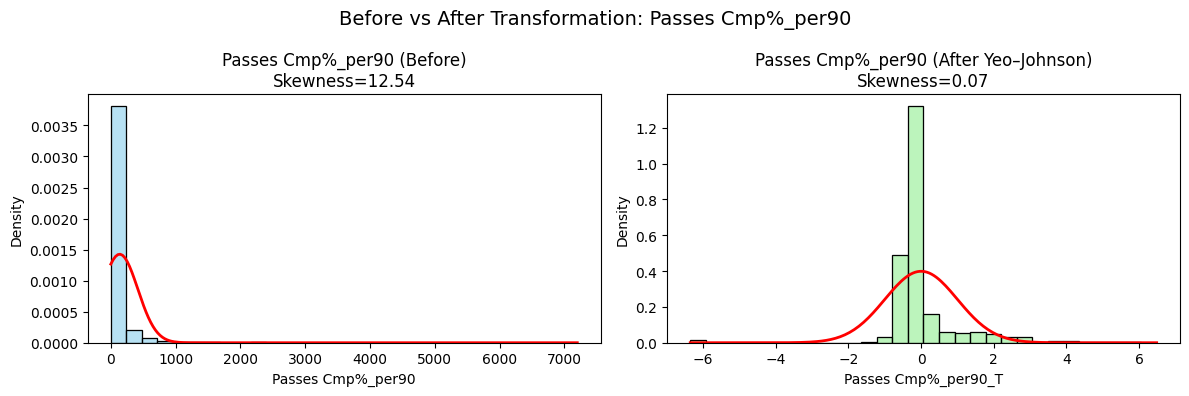

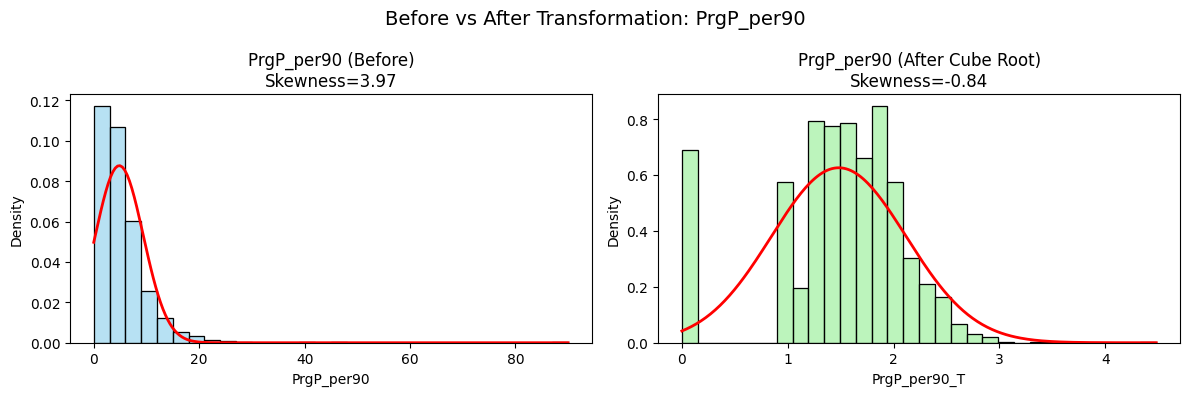

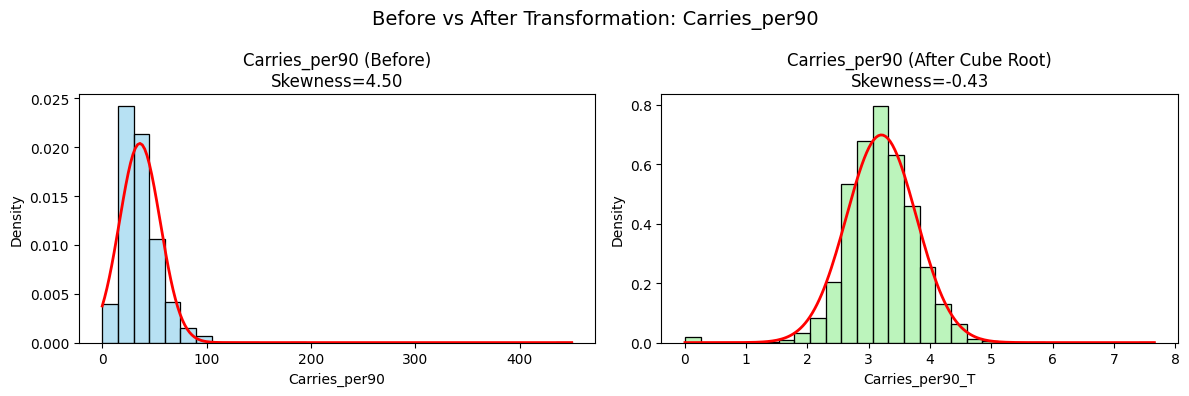

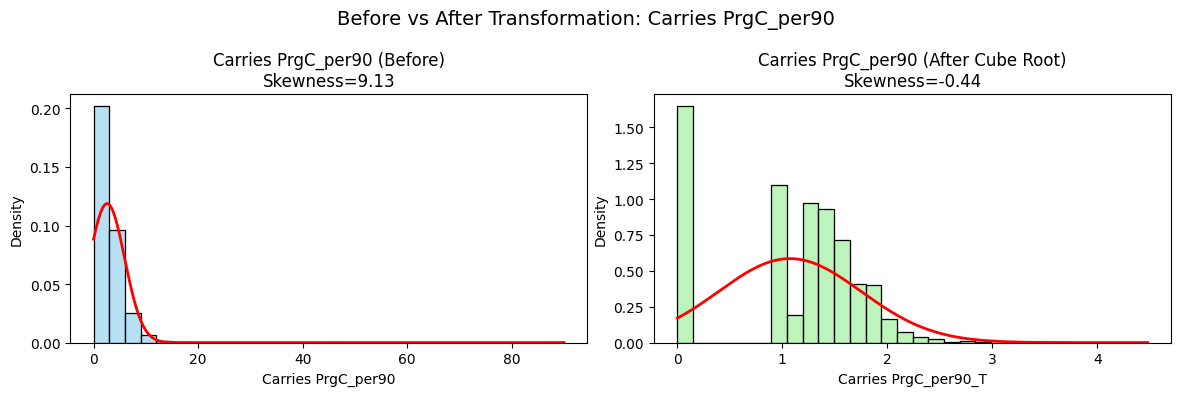

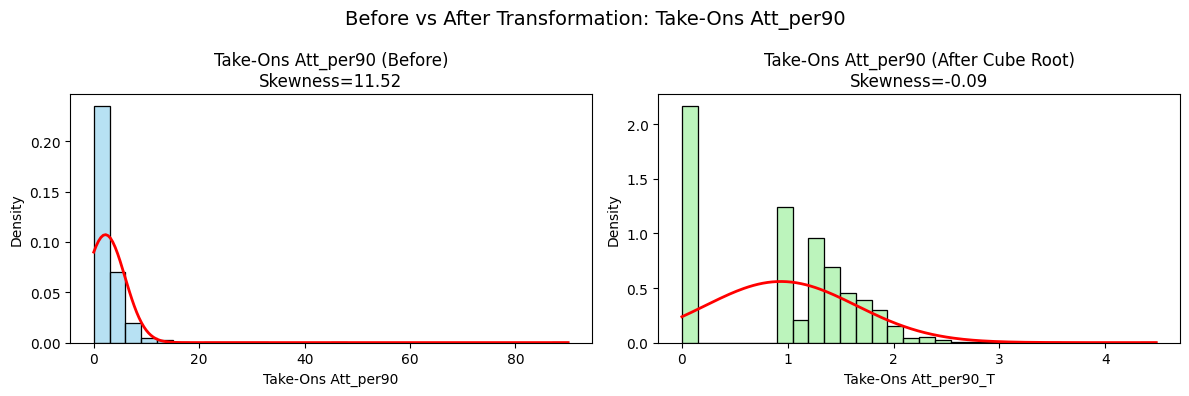

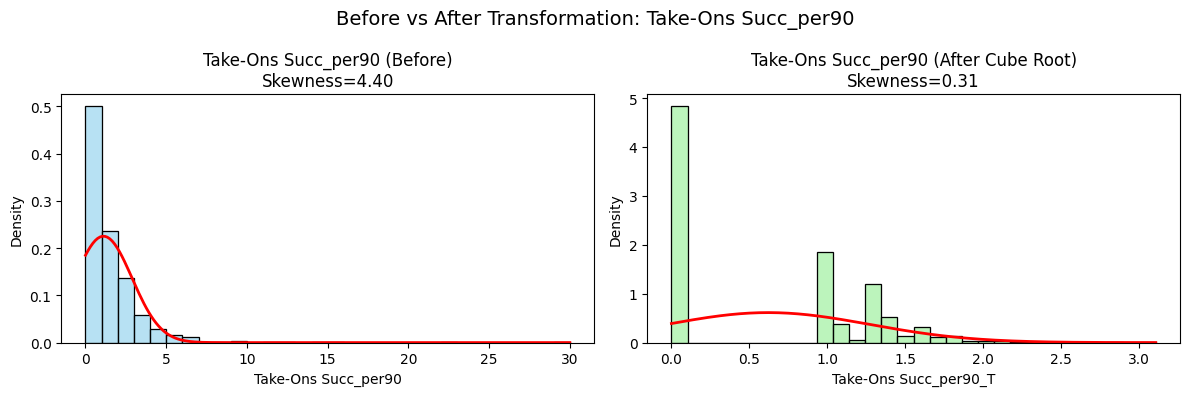

In [48]:
cols_original = [
    'Gls_per90', 'Ast_per90', 'Sh_per90',
    'SoT_per90','Touches_per90', 'Tkl_per90',
    'Int_per90', 'Blocks_per90', 'xG_per90', 'npxG_per90', 'xAG_per90',
    'SCA_per90', 'GCA_per90', 'Passes Cmp_per90', 'Passes Att_per90',
    'Passes Cmp%_per90', 'PrgP_per90', 'Carries_per90',
    'Carries PrgC_per90', 'Take-Ons Att_per90', 'Take-Ons Succ_per90'
]
# Dictionaries to track which transformation was applied
transformation_map = {}
for col in cols_special:
    transformation_map[col] = "Yeo–Johnson"
for col in cols_to_transform:
    transformation_map[col] = "Cube Root"

for col in cols_original:
    col_trans = col + "_T"

    # Drop NaNs
    data_before = df_ps[col].dropna()
    data_after = df_ps[col_trans].dropna()

    # Calculate skewness
    skew_before = skew(data_before)
    skew_after = skew(data_after)

    # Fit normal curves
    mu_before, std_before = norm.fit(data_before)
    mu_after, std_after = norm.fit(data_after)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Before transformation
    sns.histplot(data_before, stat="density", bins=30, color='skyblue', edgecolor='black', alpha=0.6, ax=axes[0])
    x_before = np.linspace(data_before.min(), data_before.max(), 200)
    axes[0].plot(x_before, norm.pdf(x_before, mu_before, std_before), 'r', linewidth=2)
    axes[0].set_title(f"{col} (Before)\nSkewness={skew_before:.2f}")

    # After transformation — dynamic method name
    method_name = transformation_map.get(col, "Unknown")
    sns.histplot(data_after, stat="density", bins=30, color='lightgreen', edgecolor='black', alpha=0.6, ax=axes[1])
    x_after = np.linspace(data_after.min(), data_after.max(), 200)
    axes[1].plot(x_after, norm.pdf(x_after, mu_after, std_after), 'r', linewidth=2)
    axes[1].set_title(f"{col} (After {method_name})\nSkewness={skew_after:.2f}")

    plt.suptitle(f"Before vs After Transformation: {col}", fontsize=14)
    plt.tight_layout()
    plt.show()


Now that the data has been **Tranformed** 
the data need to be **Standardised** so that the values will have same **Scale**

In [49]:
from sklearn.preprocessing import StandardScaler

col_to_standardize = [col for col in df_ps.columns if col.endswith('_T')]
scaler = StandardScaler()

# Transform and store in new columns with "Z_" prefix
df_ps[[f"Z_{col}" for col in col_to_standardize]] = scaler.fit_transform(df_ps[col_to_standardize])


**Preparing for Factor Analysis**

KMO: 0.801, Bartlett’s p-value: 0


c:\Users\Acer\cp_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Acer\cp_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


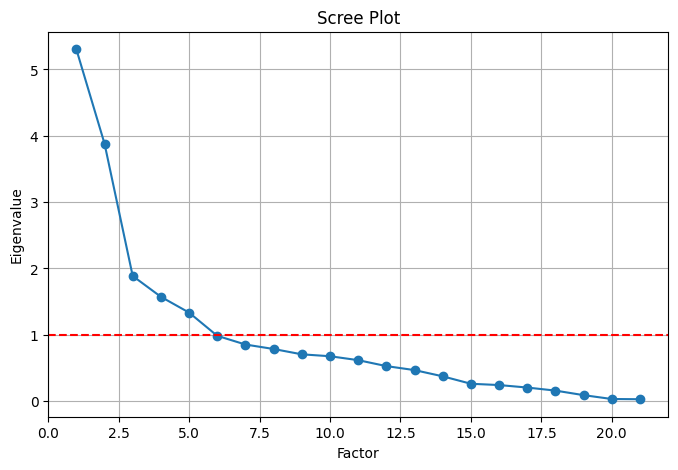

c:\Users\Acer\cp_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [50]:
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
# Prepare data for FA
cols_for_fa = [col for col in df_ps.columns if col.startswith('Z_') and col.endswith('_T')]
data_fa = df_ps[cols_for_fa].copy()

# Check KMO and Bartlett's test
kmo_all, kmo_model = calculate_kmo(data_fa)
chi_square, p_value = calculate_bartlett_sphericity(data_fa)
print(f"KMO: {kmo_model:.3f}, Bartlett’s p-value: {p_value:.3g}")

# Run Factor Analysis (5 factors, varimax rotation)
fa = FactorAnalyzer(n_factors=5, rotation='varimax')
fa.fit(data_fa)

# Get eigenvalues and eigenvectors
fa_test = FactorAnalyzer(rotation=None)  
fa_test.fit(data_fa)
eigen_values, vectors = fa_test.get_eigenvalues()

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(eigen_values)+1), eigen_values, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')  # Kaiser’s rule (eigenvalue > 1)
plt.grid(True)
plt.show()


# Assign factor scores
factor_scores = fa.transform(data_fa)
df_ps[['Passing', 'Shooting', 'Creativity', 'Dribbling', 'Defense']] = factor_scores[:, :5]

In [51]:
import pandas as pd

# Get loadings from fitted FactorAnalyzer
loadings = fa.loadings_

# Create DataFrame for factor loadings
fa_table = pd.DataFrame(
    loadings,
    index=data_fa.columns,
    columns=['Passing', 'Shooting', 'Creativity', 'Dribbling', 'Defense']
)

# Round for readability
fa_table = fa_table.round(3)

print(fa_table)


                         Passing  Shooting  Creativity  Dribbling  Defense
Z_Gls_per90_T             -0.135     0.558       0.097      0.048   -0.069
Z_Ast_per90_T             -0.016    -0.005       0.771     -0.018   -0.101
Z_GCA_per90_T             -0.027     0.113       0.679      0.067   -0.062
Z_Passes Cmp%_per90_T      0.380    -0.107      -0.104     -0.040   -0.417
Z_Sh_per90_T              -0.050     0.809       0.141      0.157   -0.059
Z_SoT_per90_T             -0.091     0.739       0.102      0.096   -0.085
Z_Touches_per90_T          0.908    -0.144      -0.005     -0.010    0.183
Z_Tkl_per90_T              0.191    -0.109       0.036     -0.004    0.349
Z_Int_per90_T              0.189    -0.162      -0.038     -0.069    0.340
Z_Blocks_per90_T           0.064    -0.056      -0.031      0.004    0.324
Z_xG_per90_T              -0.126     0.932       0.104      0.084   -0.113
Z_npxG_per90_T            -0.117     0.938       0.092      0.075   -0.117
Z_xAG_per90_T            

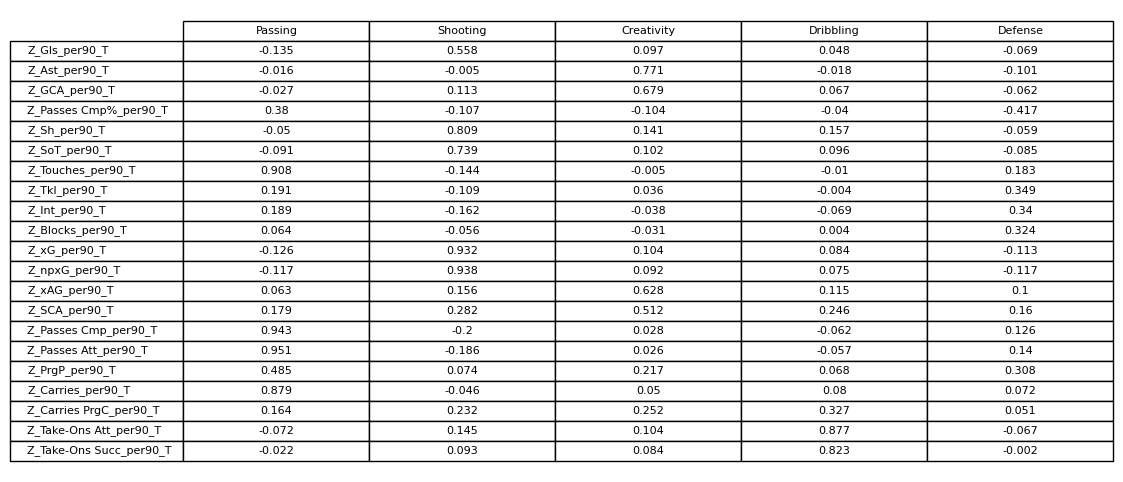

In [52]:
import matplotlib.pyplot as plt

# Plot table
fig, ax = plt.subplots(figsize=(10, 6))  # adjust size
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=fa_table.values,
    rowLabels=fa_table.index,
    colLabels=fa_table.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)  # scale table size

# Save as PNG
plt.savefig("factor_loadings.png", dpi=300, bbox_inches="tight")
plt.show()


In [53]:
# =====================
# Adjust Defense to remove cross-loading
# =====================
# Only keep actual defensive actions
defense_cols = ['Z_Tkl_per90_T', 'Z_Int_per90_T', 'Z_Blocks_per90_T']

df_ps['Defense'] = df_ps[defense_cols].mean(axis=1)

# Optional: normalize all factors 0-100
for col in ['Defense','Passing','Shooting','Creativity','Dribbling']:
    df_ps[col] = 100 * (df_ps[col] - df_ps[col].min()) / (df_ps[col].max() - df_ps[col].min())

# =====================
# Show updated factor loadings for reference
# =====================
loadings = pd.DataFrame(fa.loadings_, index=cols_for_fa, columns=['Passing','Shooting','Creativity','Dribbling','Defense'])
print(loadings.round(3))

                         Passing  Shooting  Creativity  Dribbling  Defense
Z_Gls_per90_T             -0.135     0.558       0.097      0.048   -0.069
Z_Ast_per90_T             -0.016    -0.005       0.771     -0.018   -0.101
Z_GCA_per90_T             -0.027     0.113       0.679      0.067   -0.062
Z_Passes Cmp%_per90_T      0.380    -0.107      -0.104     -0.040   -0.417
Z_Sh_per90_T              -0.050     0.809       0.141      0.157   -0.059
Z_SoT_per90_T             -0.091     0.739       0.102      0.096   -0.085
Z_Touches_per90_T          0.908    -0.144      -0.005     -0.010    0.183
Z_Tkl_per90_T              0.191    -0.109       0.036     -0.004    0.349
Z_Int_per90_T              0.189    -0.162      -0.038     -0.069    0.340
Z_Blocks_per90_T           0.064    -0.056      -0.031      0.004    0.324
Z_xG_per90_T              -0.126     0.932       0.104      0.084   -0.113
Z_npxG_per90_T            -0.117     0.938       0.092      0.075   -0.117
Z_xAG_per90_T            

In [54]:

# Map positions to categories
position_map = {
    'FW': 'Forward', 'LW': 'Left Winger', 'RW': 'Right Winger',
    'AM': 'Attacking Mid', 'CM': 'Central Mid', 'LM' : 'Left Mid', 
    'RM': 'Right Mid',
    'DM': 'Defensive Mid', 'RB': 'Right Back', 'CB': 'Centre Back', 'LB': 'Left Back'
}
df_ps['Pos_Category'] = df_ps['Pos'].map(position_map)

# Define position weights
position_weights = {
    'Forward':       {'Shooting': 0.50, 'Dribbling': 0.25, 'Creativity': 0.15, 'Passing': 0.10, 'Defense': 0.0},
    'Left Winger':   {'Shooting': 0.40, 'Dribbling': 0.30, 'Creativity': 0.20, 'Passing': 0.10, 'Defense': 0.0},
    'Right Winger':  {'Shooting': 0.40, 'Dribbling': 0.30, 'Creativity': 0.20, 'Passing': 0.10, 'Defense': 0.0},
    'Attacking Mid': {'Shooting': 0.20, 'Dribbling': 0.20, 'Creativity': 0.35, 'Passing': 0.25, 'Defense': 0.0},
    'Central Mid':   {'Shooting': 0.10, 'Dribbling': 0.15, 'Creativity': 0.25, 'Passing': 0.40, 'Defense': 0.10},
    'Defensive Mid': {'Shooting': 0.05, 'Dribbling': 0.05, 'Creativity': 0.15, 'Passing': 0.30, 'Defense': 0.45},
    'Left Mid':      {'Shooting': 0.15, 'Dribbling': 0.20, 'Creativity': 0.25, 'Passing': 0.30, 'Defense': 0.10},
    'Right Mid':     {'Shooting': 0.15, 'Dribbling': 0.20, 'Creativity': 0.25, 'Passing': 0.30, 'Defense': 0.10},
    'Defender':      {'Shooting': 0.05, 'Dribbling': 0.05, 'Creativity': 0.10, 'Passing': 0.25, 'Defense': 0.55}
}

# Calculate Impact Score
def calculate_impact(row):
    weights = position_weights.get(row['Pos_Category'], {k: 0.2 for k in ['Shooting', 'Passing', 'Creativity', 'Dribbling', 'Defense']})
    return sum(row[attr] * weights.get(attr, 0) for attr in ['Shooting', 'Passing', 'Creativity', 'Dribbling', 'Defense'])

df_ps['Impact_Score'] = df_ps.apply(calculate_impact, axis=1)

In [55]:
# Merge DOB and Start_year from df_pl
df_ps = df_ps.merge(
    df_pl[['Player_ID', 'DOB', 'Start_year']], 
    on='Player_ID', 
    how='left'
)

# Calculate Age and Experience
df_ps['DOB'] = pd.to_datetime(df_ps['DOB'])
df_ps['Age'] = ((df_ps['Date'] - df_ps['DOB']).dt.days / 365.25).round(1)
df_ps['Experience'] = (df_ps['Date'].dt.year - pd.to_numeric(df_ps['Start_year'], errors='coerce')).clip(lower=0)

# Age grouping
df_ps['Age_Group'] = pd.cut(
    df_ps['Age'], 
    bins=[0, 22, 26, 30, 35, 50], 
    labels=['<=22', '23-26', '27-30', '31-35', '36+'], 
    include_lowest=True
)

# Experience grouping
df_ps['Experience_Tier'] = pd.cut(
    df_ps['Experience'], 
    bins=[0, 3, 7, 12, 50],  # Adjust as needed
    labels=['Rookie', 'Mid-Career', 'Veteran', 'Legend'], 
    include_lowest=True
)

# See head of selected columns
print(df_ps[['Age', 'Age_Group', 'Experience', 'Experience_Tier']].head())


    Age Age_Group  Experience Experience_Tier
0  19.8      <=22           1          Rookie
1  19.8      <=22           1          Rookie
2  19.8      <=22           1          Rookie
3  19.9      <=22           1          Rookie
4  19.9      <=22           1          Rookie


In [56]:
age_labels = [
    '<=22: Young Talent', 
    '23-26: Prime Years', 
    '27-30: Experienced', 
    '31-35: Senior', 
    '36+: Veteran'
]

df_ps['Age_Group'] = pd.cut(
    df_ps['Age'], 
    bins=[0, 22, 26, 30, 35, 50], 
    labels=age_labels, 
    include_lowest=True
)


In [57]:
df_ps.head()

,Match_ID,Player_ID,Manager_ID,Date,Outcome,Pos,Min,Start_encoded,CrdY_flag,CrdR_flag,...,Dribbling,Defense,Pos_Category,Impact_Score,DOB,Start_year,Age,Experience,Age_Group,Experience_Tier
0,G01,P01,M01,2017-08-13,W,FW,79,1,0,0,...,51.990911,16.277735,Forward,41.234421,1997-10-31,2016,19.8,1,<=22: Young Talent,Rookie
1,G02,P01,M01,2017-08-19,W,FW,74,1,0,0,...,67.246648,38.957771,Forward,46.035666,1997-10-31,2016,19.8,1,<=22: Young Talent,Rookie
2,G03,P01,M01,2017-08-26,W,FW,24,0,0,0,...,73.592268,0.000000,Forward,50.321562,1997-10-31,2016,19.8,1,<=22: Young Talent,Rookie
3,G04,P01,M01,2017-09-09,D,FW,71,1,0,0,...,30.984985,0.000000,Forward,38.577424,1997-10-31,2016,19.9,1,<=22: Young Talent,Rookie
4,G05,P01,M01,2017-09-17,W,FW,60,1,0,0,...,55.813187,30.159529,Forward,36.593803,1997-10-31,2016,19.9,1,<=22: Young Talent,Rookie


In [58]:
# Drop intermediate columns
df_ps = df_ps.drop([ 'Outcome' , 'Min', 'Gls_per90', 'Ast_per90', 'Sh_per90', 'SoT_per90',
       'Touches_per90', 'Tkl_per90', 'Int_per90', 'Blocks_per90', 'xG_per90',
       'npxG_per90', 'xAG_per90', 'SCA_per90', 'GCA_per90', 'Passes Cmp_per90',
       'Passes Att_per90', 'Passes Cmp%_per90', 'PrgP_per90', 'Carries_per90',
       'Carries PrgC_per90', 'Take-Ons Att_per90', 'Take-Ons Succ_per90' ,'Gls_per90_T', 'Ast_per90_T', 'GCA_per90_T', 'Passes Cmp%_per90_T',
       'Sh_per90_T', 'SoT_per90_T', 'Touches_per90_T', 'Tkl_per90_T',
       'Int_per90_T', 'Blocks_per90_T', 'xG_per90_T', 'npxG_per90_T',
       'xAG_per90_T', 'SCA_per90_T', 'Passes Cmp_per90_T',
       'Passes Att_per90_T', 'PrgP_per90_T', 'Carries_per90_T',
       'Carries PrgC_per90_T', 'Take-Ons Att_per90_T', 'Take-Ons Succ_per90_T','DOB', 'Start_year', 'Pos', 'Age', 'Experience'], axis=1, errors='ignore')

# Display final columns
display(df_ps.head().T)
display(df_ps.info())

,0,1,2,3,4
Match_ID,G01,G02,G03,G04,G05
Player_ID,P01,P01,P01,P01,P01
Manager_ID,M01,M01,M01,M01,M01
Date,2017-08-13 00:00:00,2017-08-19 00:00:00,2017-08-26 00:00:00,2017-09-09 00:00:00,2017-09-17 00:00:00
Start_encoded,1,1,0,1,1
CrdY_flag,0,0,0,0,0
CrdR_flag,0,0,0,0,0
Outcome_encoded,2,2,2,0,2
Venue_Away,0,1,0,1,0
Venue_Home,1,0,1,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Match_ID                 2683 non-null   object        
 1   Player_ID                2683 non-null   object        
 2   Manager_ID               2683 non-null   object        
 3   Date                     2683 non-null   datetime64[ns]
 4   Start_encoded            2683 non-null   int32         
 5   CrdY_flag                2683 non-null   int32         
 6   CrdR_flag                2683 non-null   int32         
 7   Outcome_encoded          2683 non-null   int32         
 8   Venue_Away               2683 non-null   int32         
 9   Venue_Home               2683 non-null   int32         
 10  PK_bin                   2683 non-null   category      
 11  PKatt_bin                2683 non-null   category      
 12  Z_Gls_per90_T            2683 non-

None

In [59]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Convert to datetime (dd/mm/yyyy format)
df_ps['Date'] = pd.to_datetime(df_ps['Date'], format='%d/%m/%Y')

# Extract year
df_ps['Year'] = df_ps['Date'].dt.year

# Encode year
le = LabelEncoder()
df_ps['Year_Encoded'] = le.fit_transform(df_ps['Year'])


print(df_ps[['Year', 'Year_Encoded']].head())


   Year  Year_Encoded
0  2017             0
1  2017             0
2  2017             0
3  2017             0
4  2017             0


In [60]:
from sklearn.preprocessing import LabelEncoder

# Label encode ordinal variables
le_age = LabelEncoder()
le_exp = LabelEncoder()
# Label encode ordered categories
df_ps['Age_Group_Code'] = le_age.fit_transform(df_ps['Age_Group'])
df_ps['Experience_Tier_Code'] = le_exp.fit_transform(df_ps['Experience_Tier'])

# One-hot encode position
df_ps = pd.get_dummies(df_ps, columns=['Pos_Category'], prefix='Pos', dtype=int)


In [61]:
df_ps.isnull().sum()

Match_ID                   0
Player_ID                  0
Manager_ID                 0
Date                       0
Start_encoded              0
CrdY_flag                  0
CrdR_flag                  0
Outcome_encoded            0
Venue_Away                 0
Venue_Home                 0
PK_bin                     0
PKatt_bin                  0
Z_Gls_per90_T              0
Z_Ast_per90_T              0
Z_GCA_per90_T              0
Z_Passes Cmp%_per90_T      0
Z_Sh_per90_T               0
Z_SoT_per90_T              0
Z_Touches_per90_T          0
Z_Tkl_per90_T              0
Z_Int_per90_T              0
Z_Blocks_per90_T           0
Z_xG_per90_T               0
Z_npxG_per90_T             0
Z_xAG_per90_T              0
Z_SCA_per90_T              0
Z_Passes Cmp_per90_T       0
Z_Passes Att_per90_T       0
Z_PrgP_per90_T             0
Z_Carries_per90_T          0
Z_Carries PrgC_per90_T     0
Z_Take-Ons Att_per90_T     0
Z_Take-Ons Succ_per90_T    0
Passing                    0
Shooting      

In [62]:
df_mf.head(5)

,ManagerFormation_ID,Manager_ID,Formation,Attacking_Style,Defensive_Style,Build_Up,Pressing,Line_Height,Width,Overlap,Compactness
0,MF01,M01,4-2-3-1,Counter,Low Block,Direct,Medium Press,Low,Narrow,Minimal,Very Compact
1,MF02,M02,4-2-3-1,Fast Transitions,Mid Block,Mixed,High Press,Medium,Balanced,Moderate,Compact
2,MF03,M03,4-2-2-2,High Press,High Line,Vertical,Extreme Press,High,Balanced,Frequent,Compact
3,MF04,M04,4-3-3,Structured,High Line,Positional,High Press,High,Wide,Frequent,Compact
4,MF05,M04,4-2-3-1,Structured,High Line,Positional,High Press,High,Balanced,Moderate,Compact


In [63]:
# Group by Manager_ID and take mode for each categorical column
df_mgr_mode = (
    df_mf
    .groupby('Manager_ID')
    .agg(lambda x: x.mode()[0])  # pick first mode if tie
    .reset_index()
)

# Merge into player dataset
df_ps = df_ps.merge(df_mgr_mode, on='Manager_ID', how='left')

print(df_ps.head())


  Match_ID Player_ID Manager_ID       Date  Start_encoded  CrdY_flag  \
0      G01       P01        M01 2017-08-13              1          0   
1      G02       P01        M01 2017-08-19              1          0   
2      G03       P01        M01 2017-08-26              0          0   
3      G04       P01        M01 2017-09-09              1          0   
4      G05       P01        M01 2017-09-17              1          0   

   CrdR_flag  Outcome_encoded  Venue_Away  Venue_Home  ...  \
0          0                2           0           1  ...   
1          0                2           1           0  ...   
2          0                2           0           1  ...   
3          0                0           1           0  ...   
4          0                2           0           1  ...   

  ManagerFormation_ID Formation  Attacking_Style  Defensive_Style  Build_Up  \
0                MF01   4-2-3-1          Counter        Low Block    Direct   
1                MF01   4-2-3-1     

In [64]:
# Merge height and weight into player stats df
df_ps = df_ps.merge(
    df_pl[['Player_ID','Height(cm)', 'Weight(kg)', 'BMI']],
    on='Player_ID',
    how='left'
)
df_ps['Height_Group'] = pd.cut(
    df_ps['Height(cm)'],
    bins=[0, 170, 180, 190, 250],
    labels=['Short', 'Average', 'Tall', 'Very Tall']
)
# Categorize BMI
df_ps['BMI_Category'] = pd.cut(
    df_ps['BMI'],
    bins=[0, 20, 25, 30, 100],  # Underweight, Normal, Overweight, Very High
    labels=['Low', 'Normal', 'High', 'Very High']
)

# Optional: Combine Height and BMI category
df_ps['Physique_Type'] = df_ps['Height_Group'].astype(str) + "_" + df_ps['BMI_Category'].astype(str)


In [65]:
df_ps.columns

Index(['Match_ID', 'Player_ID', 'Manager_ID', 'Date', 'Start_encoded',
       'CrdY_flag', 'CrdR_flag', 'Outcome_encoded', 'Venue_Away', 'Venue_Home',
       'PK_bin', 'PKatt_bin', 'Z_Gls_per90_T', 'Z_Ast_per90_T',
       'Z_GCA_per90_T', 'Z_Passes Cmp%_per90_T', 'Z_Sh_per90_T',
       'Z_SoT_per90_T', 'Z_Touches_per90_T', 'Z_Tkl_per90_T', 'Z_Int_per90_T',
       'Z_Blocks_per90_T', 'Z_xG_per90_T', 'Z_npxG_per90_T', 'Z_xAG_per90_T',
       'Z_SCA_per90_T', 'Z_Passes Cmp_per90_T', 'Z_Passes Att_per90_T',
       'Z_PrgP_per90_T', 'Z_Carries_per90_T', 'Z_Carries PrgC_per90_T',
       'Z_Take-Ons Att_per90_T', 'Z_Take-Ons Succ_per90_T', 'Passing',
       'Shooting', 'Creativity', 'Dribbling', 'Defense', 'Impact_Score',
       'Age_Group', 'Experience_Tier', 'Year', 'Year_Encoded',
       'Age_Group_Code', 'Experience_Tier_Code', 'Pos_Attacking Mid',
       'Pos_Central Mid', 'Pos_Centre Back', 'Pos_Defensive Mid',
       'Pos_Forward', 'Pos_Left Back', 'Pos_Left Winger', 'Pos_Right Back',


In [66]:
df_ps[['Age_Group', 'Experience_Tier', 'Formation', 
       'Attacking_Style', 'Defensive_Style', 'Build_Up', 
       'Pressing', 'Line_Height', 'Width', 'Overlap', 
       'Compactness', 'Physique_Type']].isnull().sum()

Age_Group          0
Experience_Tier    0
Formation          0
Attacking_Style    0
Defensive_Style    0
Build_Up           0
Pressing           0
Line_Height        0
Width              0
Overlap            0
Compactness        0
Physique_Type      0
dtype: int64

**MCA for manageral formation**


In [67]:
import pandas as pd
import prince

# Columns for MCA
mca_cols = [
    'Formation', 'Attacking_Style', 'Defensive_Style', 'Build_Up', 'Pressing',
    'Line_Height', 'Width', 'Overlap', 'Compactness',
    'Physique_Type', 'Age_Group', 'Experience_Tier'
]

# Step 1: Select columns and replace non-standard missing values
df_mca = df_ps[mca_cols].replace(["", "?", "Unknown"], pd.NA)

# Step 2: Drop rows with ANY missing values
df_mca = df_mca.dropna()
print(f"Final shape: {df_mca.shape}")

# Step 3: Ensure all columns are categorical (MCA requirement)
df_mca = df_mca.astype(str)

# Step 4: Initialize and fit MCA
mca = prince.MCA(
    n_components=7,
    n_iter=10,
    random_state=42
)
mca = mca.fit(df_mca)  # Should work now

# Step 5: Transform and merge
mca_components = mca.transform(df_mca)
mca_components.columns = [f'Tactic_Component_{i+1}' for i in range(mca_components.shape[1])]
df_ps_mca = df_ps.join(mca_components)

print(df_ps_mca.head())

Final shape: (2683, 12)


  Match_ID Player_ID Manager_ID       Date  Start_encoded  CrdY_flag  \
0      G01       P01        M01 2017-08-13              1          0   
1      G02       P01        M01 2017-08-19              1          0   
2      G03       P01        M01 2017-08-26              0          0   
3      G04       P01        M01 2017-09-09              1          0   
4      G05       P01        M01 2017-09-17              1          0   

   CrdR_flag  Outcome_encoded  Venue_Away  Venue_Home  ... Height_Group  \
0          0                2           0           1  ...      Average   
1          0                2           1           0  ...      Average   
2          0                2           0           1  ...      Average   
3          0                0           1           0  ...      Average   
4          0                2           0           1  ...      Average   

  BMI_Category   Physique_Type  Tactic_Component_1  Tactic_Component_2  \
0       Normal  Average_Normal            

In [68]:
# Get eigenvalues (inertia)
eigenvalues = mca.eigenvalues_

# Proportion of variance explained
explained_var = eigenvalues / eigenvalues.sum()

# Cumulative variance explained
cum_var = explained_var.cumsum()

# Build table
mca_variance_table = pd.DataFrame({
    "Eigenvalue (Inertia)": eigenvalues,
    "Proportion of Variance": explained_var,
    "Cumulative Variance": cum_var
})

# Rename for report style
mca_variance_table.index = [f"Component {i+1}" for i in range(len(eigenvalues))]

print(mca_variance_table.round(3))


             Eigenvalue (Inertia)  Proportion of Variance  Cumulative Variance
Component 1                 0.501                   0.227                0.227
Component 2                 0.368                   0.167                0.393
Component 3                 0.339                   0.153                0.547
Component 4                 0.317                   0.144                0.690
Component 5                 0.267                   0.121                0.811
Component 6                 0.214                   0.097                0.908
Component 7                 0.204                   0.092                1.000


In [69]:
# Get all MCA variable contributions (full output)
loadings = mca.column_coordinates(df_mca)
loadings = loadings.rename(columns={i: f"Tactic_Component_{i+1}" for i in range(7)})

# Reset index to see variable names clearly
loadings = loadings.reset_index().rename(columns={"index": "Variable"})

# Display ALL variables sorted by contribution to Component 1
print(loadings.sort_values("Tactic_Component_1", key=abs, ascending=False))

                                Variable  Tactic_Component_1  \
31                      Line_Height__Low            2.030603   
20            Defensive_Style__Low Block            1.916983   
22                      Build_Up__Direct            1.774729   
34                         Width__Narrow            1.573160   
42             Compactness__Very Compact            1.566370   
16            Attacking_Style__Wing Play            1.511067   
5               Attacking_Style__Counter            1.474786   
27               Pressing__Extreme Press           -1.361329   
2                     Formation__4-2-2-2           -1.361329   
52               Experience_Tier__Legend            1.344052   
38                      Overlap__Minimal            1.317174   
18              Defensive_Style__Compact            1.274014   
0                     Formation__3-4-2-1            1.090428   
9                Attacking_Style__Hybrid            1.090428   
26                    Build_Up__Vertical

C:\Users\Acer\AppData\Local\Temp\ipykernel_12660\1544263691.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (cols[0][i], cols[1][i]), fontsize=8, color="red")


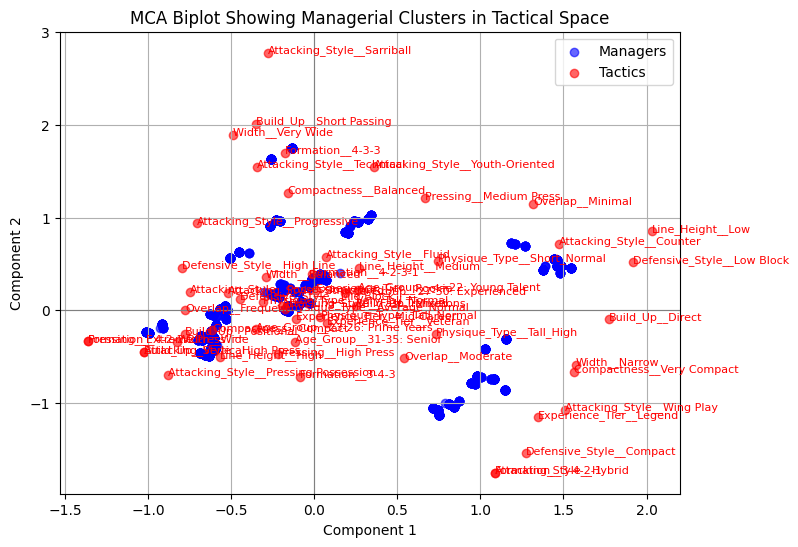

In [70]:
import matplotlib.pyplot as plt

# Row coordinates (managers)
rows = mca.row_coordinates(df_mca)

# Column coordinates (tactical variables)
cols = mca.column_coordinates(df_mca)

# Plot biplot (first 2 components)
plt.figure(figsize=(8,6))

# Plot managers
plt.scatter(rows[0], rows[1], alpha=0.6, label="Managers", color="blue")

# Plot tactical variables
plt.scatter(cols[0], cols[1], alpha=0.6, label="Tactics", color="red")

# Annotate tactical variables
for i, txt in enumerate(cols.index):
    plt.annotate(txt, (cols[0][i], cols[1][i]), fontsize=8, color="red")

plt.axhline(0, color="gray", linewidth=0.8)
plt.axvline(0, color="gray", linewidth=0.8)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("MCA Biplot Showing Managerial Clusters in Tactical Space")
plt.legend()
plt.grid(True)
plt.show()


In [71]:
for component in loadings.columns[1:]:  # Skip "Variable" column
    print(f"\n--- {component} (Top Contributors) ---")
    print(
        loadings[["Variable", component]]
        .sort_values(component, key=abs, ascending=False)
        .head(20)    )


--- Tactic_Component_1 (Top Contributors) ---
                                Variable  Tactic_Component_1
31                      Line_Height__Low            2.030603
20            Defensive_Style__Low Block            1.916983
22                      Build_Up__Direct            1.774729
34                         Width__Narrow            1.573160
42             Compactness__Very Compact            1.566370
16            Attacking_Style__Wing Play            1.511067
5               Attacking_Style__Counter            1.474786
27               Pressing__Extreme Press           -1.361329
2                     Formation__4-2-2-2           -1.361329
52               Experience_Tier__Legend            1.344052
38                      Overlap__Minimal            1.317174
18              Defensive_Style__Compact            1.274014
0                     Formation__3-4-2-1            1.090428
9                Attacking_Style__Hybrid            1.090428
26                    Build_Up__Vertic

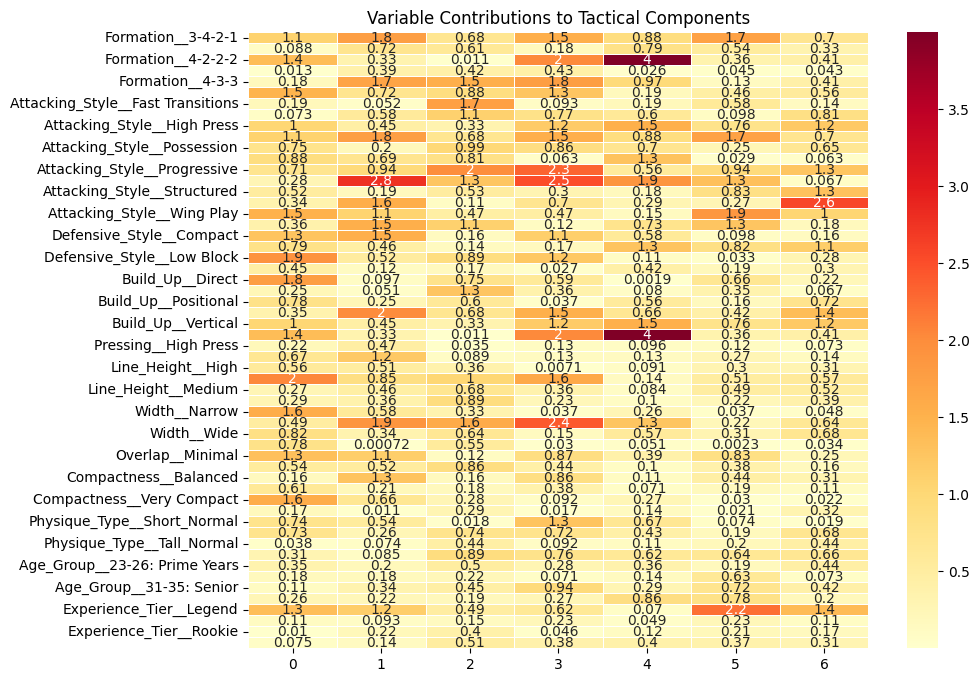

In [72]:
# Get absolute loadings for all components
loadings_abs = mca.column_coordinates(df_mca).abs()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    loadings_abs,
    annot=True,  # Show values
    cmap="YlOrRd",
    linewidths=0.5
)
plt.title("Variable Contributions to Tactical Components")
plt.show()

In [73]:
df_ps_mca.columns

Index(['Match_ID', 'Player_ID', 'Manager_ID', 'Date', 'Start_encoded',
       'CrdY_flag', 'CrdR_flag', 'Outcome_encoded', 'Venue_Away', 'Venue_Home',
       'PK_bin', 'PKatt_bin', 'Z_Gls_per90_T', 'Z_Ast_per90_T',
       'Z_GCA_per90_T', 'Z_Passes Cmp%_per90_T', 'Z_Sh_per90_T',
       'Z_SoT_per90_T', 'Z_Touches_per90_T', 'Z_Tkl_per90_T', 'Z_Int_per90_T',
       'Z_Blocks_per90_T', 'Z_xG_per90_T', 'Z_npxG_per90_T', 'Z_xAG_per90_T',
       'Z_SCA_per90_T', 'Z_Passes Cmp_per90_T', 'Z_Passes Att_per90_T',
       'Z_PrgP_per90_T', 'Z_Carries_per90_T', 'Z_Carries PrgC_per90_T',
       'Z_Take-Ons Att_per90_T', 'Z_Take-Ons Succ_per90_T', 'Passing',
       'Shooting', 'Creativity', 'Dribbling', 'Defense', 'Impact_Score',
       'Age_Group', 'Experience_Tier', 'Year', 'Year_Encoded',
       'Age_Group_Code', 'Experience_Tier_Code', 'Pos_Attacking Mid',
       'Pos_Central Mid', 'Pos_Centre Back', 'Pos_Defensive Mid',
       'Pos_Forward', 'Pos_Left Back', 'Pos_Left Winger', 'Pos_Right Back',


In [74]:
df_model = df_ps_mca.copy()
# Drop unnecessary columns
cols_to_drop = ['Age_Group', 'Experience_Tier', 'Age_Group_Code',
       'Experience_Tier_Code','Z_Gls_per90_T', 'Z_Ast_per90_T', 'Z_GCA_per90_T',
       'Z_Passes Cmp%_per90_T', 'Z_Sh_per90_T', 'Z_SoT_per90_T',
       'Z_Touches_per90_T', 'Z_Tkl_per90_T', 'Z_Int_per90_T',
       'Z_Blocks_per90_T', 'Z_xG_per90_T', 'Z_npxG_per90_T', 'Z_xAG_per90_T',
       'Z_SCA_per90_T', 'Z_Passes Cmp_per90_T', 'Z_Passes Att_per90_T',
       'Z_PrgP_per90_T', 'Z_Carries_per90_T', 'Z_Carries PrgC_per90_T',
       'Z_Take-Ons Att_per90_T', 'Z_Take-Ons Succ_per90_T',  'ManagerFormation_ID', 'Formation',
       'Attacking_Style', 'Defensive_Style', 'Build_Up', 'Pressing',
       'Line_Height', 'Width', 'Overlap', 'Compactness', 'Height(cm)',
       'Weight(kg)', 'BMI', 'Height_Group', 'BMI_Category', 'Physique_Type']
df_model = df_model.drop([col for col in cols_to_drop if col in df_model.columns], axis=1)
# Display final model columns
display(df_model.head().T)
display(df_model.info())

,0,1,2,3,4
Match_ID,G01,G02,G03,G04,G05
Player_ID,P01,P01,P01,P01,P01
Manager_ID,M01,M01,M01,M01,M01
Date,2017-08-13 00:00:00,2017-08-19 00:00:00,2017-08-26 00:00:00,2017-09-09 00:00:00,2017-09-17 00:00:00
Start_encoded,1,1,0,1,1
CrdY_flag,0,0,0,0,0
CrdR_flag,0,0,0,0,0
Outcome_encoded,2,2,2,0,2
Venue_Away,0,1,0,1,0
Venue_Home,1,0,1,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Match_ID            2683 non-null   object        
 1   Player_ID           2683 non-null   object        
 2   Manager_ID          2683 non-null   object        
 3   Date                2683 non-null   datetime64[ns]
 4   Start_encoded       2683 non-null   int32         
 5   CrdY_flag           2683 non-null   int32         
 6   CrdR_flag           2683 non-null   int32         
 7   Outcome_encoded     2683 non-null   int32         
 8   Venue_Away          2683 non-null   int32         
 9   Venue_Home          2683 non-null   int32         
 10  PK_bin              2683 non-null   category      
 11  PKatt_bin           2683 non-null   category      
 12  Passing             2683 non-null   float64       
 13  Shooting            2683 non-null   float64     

None

In [75]:
df_model['PK_bin'] = df_model['PK_bin'].astype(int)  # Convert '0'/'1' → 0/1
# Map categories to numbers (preserving order)
df_model['PKatt_bin'] = df_model['PKatt_bin'].map({'0': 0, '1': 1, '2+': 2}).astype(int)

In [76]:
df_model.columns

Index(['Match_ID', 'Player_ID', 'Manager_ID', 'Date', 'Start_encoded',
       'CrdY_flag', 'CrdR_flag', 'Outcome_encoded', 'Venue_Away', 'Venue_Home',
       'PK_bin', 'PKatt_bin', 'Passing', 'Shooting', 'Creativity', 'Dribbling',
       'Defense', 'Impact_Score', 'Year', 'Year_Encoded', 'Pos_Attacking Mid',
       'Pos_Central Mid', 'Pos_Centre Back', 'Pos_Defensive Mid',
       'Pos_Forward', 'Pos_Left Back', 'Pos_Left Winger', 'Pos_Right Back',
       'Tactic_Component_1', 'Tactic_Component_2', 'Tactic_Component_3',
       'Tactic_Component_4', 'Tactic_Component_5', 'Tactic_Component_6',
       'Tactic_Component_7'],
      dtype='object')

In [77]:
from sklearn.preprocessing import MinMaxScaler

# Features to normalize
cols_to_normalize = ["Passing", "Shooting", "Creativity", "Dribbling", "Defense", "Impact_Score"]

# Position columns
position_cols = [
    'Pos_Attacking Mid', 'Pos_Central Mid', 'Pos_Centre Back', 'Pos_Defensive Mid',
    'Pos_Forward', 'Pos_Left Back', 'Pos_Left Winger', 'Pos_Right Back'
]

# Loop over each position column
for pos_col in position_cols:
    # Get players belonging to this position
    players_in_pos = df_model[df_model[pos_col] == 1].copy()
    
    if not players_in_pos.empty:
        scaler = MinMaxScaler(feature_range=(0, 100))
        df_model.loc[players_in_pos.index, cols_to_normalize] = scaler.fit_transform(players_in_pos[cols_to_normalize])

print(df_model.head())


  Match_ID Player_ID Manager_ID       Date  Start_encoded  CrdY_flag  \
0      G01       P01        M01 2017-08-13              1          0   
1      G02       P01        M01 2017-08-19              1          0   
2      G03       P01        M01 2017-08-26              0          0   
3      G04       P01        M01 2017-09-09              1          0   
4      G05       P01        M01 2017-09-17              1          0   

   CrdR_flag  Outcome_encoded  Venue_Away  Venue_Home  ...  Pos_Left Back  \
0          0                2           0           1  ...              0   
1          0                2           1           0  ...              0   
2          0                2           0           1  ...              0   
3          0                0           1           0  ...              0   
4          0                2           0           1  ...              0   

   Pos_Left Winger  Pos_Right Back  Tactic_Component_1  Tactic_Component_2  \
0                0        

In [78]:
# Pick best tactical component for each player
df_model["Best_Tactic"] = df_model[
    ["Tactic_Component_1","Tactic_Component_2","Tactic_Component_3",
     "Tactic_Component_4","Tactic_Component_5","Tactic_Component_6","Tactic_Component_7"]
].idxmax(axis=1)

# Example output
print(df_model[["Player_ID", "Best_Tactic"]].head())


  Player_ID         Best_Tactic
0       P01  Tactic_Component_1
1       P01  Tactic_Component_1
2       P01  Tactic_Component_1
3       P01  Tactic_Component_1
4       P01  Tactic_Component_1


In [79]:
df_model.to_csv(r'C:\Users\Acer\cp_env\Analysis\df_model.csv', index=False)

In [80]:
tactics_count = (
    df_model.groupby(['Manager_ID', 'Best_Tactic']).size().reset_index(name='Count')
)
print(tactics_count.head(30))


   Manager_ID         Best_Tactic  Count
0         M01  Tactic_Component_1     91
1         M02  Tactic_Component_2     31
2         M02  Tactic_Component_6    288
3         M03  Tactic_Component_5     69
4         M04  Tactic_Component_6    259
5         M05  Tactic_Component_3     38
6         M06  Tactic_Component_1     71
7         M07  Tactic_Component_2     74
8         M08  Tactic_Component_2    177
9         M09  Tactic_Component_1     33
10        M09  Tactic_Component_4    162
11        M10  Tactic_Component_4     15
12        M10  Tactic_Component_7     25
13        M11  Tactic_Component_7     10
14        M12  Tactic_Component_7     19
15        M13  Tactic_Component_7    211
16        M14  Tactic_Component_1    118
17        M15  Tactic_Component_1     28
18        M16  Tactic_Component_1    110
19        M16  Tactic_Component_6     49
20        M17  Tactic_Component_3      4
21        M17  Tactic_Component_4     65
22        M18  Tactic_Component_7     83
23        M19  T

In [81]:
import json

# Count how many times each tactic is used by each manager
manager_tactics = (
    df_model.groupby(['Manager_ID', 'Best_Tactic'])
    .size()
    .reset_index(name='Count')
    .groupby('Manager_ID')
    .apply(lambda x: [{"tactic": row['Best_Tactic'], "count": row['Count']} 
                      for _, row in x.iterrows()])
    .to_dict()
)

with open("manager_tactics.json", "w") as f:
    json.dump(manager_tactics, f, indent=4)

print("Manager tactics saved to manager_tactics.json")


Manager tactics saved to manager_tactics.json


C:\Users\Acer\AppData\Local\Temp\ipykernel_12660\1129326240.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [{"tactic": row['Best_Tactic'], "count": row['Count']}


**Model**

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_sample_weight

# =====================
# Features & Target
# =====================
X = df_model.drop(columns=[
    "Best_Tactic", 'Match_ID', "Player_ID", "Manager_ID", 'Year', 'Date',
    'Tactic_Component_1','Tactic_Component_2','Tactic_Component_3',
    'Tactic_Component_4','Tactic_Component_5','Tactic_Component_6','Tactic_Component_7', 'Impact_Score'
])
le = LabelEncoder()
y = le.fit_transform(df_model["Best_Tactic"])
# Identify numeric features
numeric_features = ['Passing', 'Shooting', 'Creativity', 'Dribbling', 'Defense']

# =====================
# Train/Test Split
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# =====================
# Column Transformer: scale only numeric columns
# =====================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)  # scale only numeric
    ],
    remainder="passthrough"  # keep other features as is
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# =====================
# Models
# =====================
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=10, min_samples_split=10,
        min_samples_leaf=4, max_features="sqrt", class_weight="balanced",
        random_state=42
    ),
    "GradientBoost": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=3,
        min_samples_split=2, min_samples_leaf=2, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, learning_rate=0.01, max_depth=7,
        subsample=0.7, colsample_bytree=0.7,
        eval_metric="mlogloss", random_state=42, n_jobs=-1
    ),
    "NeuralNet": MLPClassifier(
        hidden_layer_sizes=(128, 64), activation="relu", solver="adam",
        max_iter=300, random_state=42
    )
}

# =====================
# Train & Evaluate
# =====================
results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")

    if name in ["GradientBoost", "XGBoost"]:
        sample_weights = compute_sample_weight("balanced", y_train)
        model.fit(X_train_scaled if name == "NeuralNet" else X_train, 
                  y_train, sample_weight=sample_weights)
    elif name == "NeuralNet":
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)

    # Predictions
    if name == "NeuralNet":
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    report = classification_report(y_test, y_pred)

    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} Macro F1: {macro_f1:.4f}")
    print(report)

    results[name] = {"accuracy": acc, "macro_f1": macro_f1}

# =====================
# Model Comparison
# =====================
print("\n=== Model Comparison ===")
for name, res in results.items():
    print(f"{name:15} | Accuracy: {res['accuracy']:.4f} | Macro F1: {res['macro_f1']:.4f}")



=== Training RandomForest ===
RandomForest Accuracy: 0.6811
RandomForest Macro F1: 0.6370
              precision    recall  f1-score   support

           0       0.74      0.43      0.55       113
           1       0.78      0.81      0.79       109
           2       0.58      0.67      0.62       135
           3       0.56      0.84      0.67        61
           4       0.29      0.35      0.32        17
           5       0.79      0.69      0.74       149
           6       0.75      0.80      0.78        87

    accuracy                           0.68       671
   macro avg       0.64      0.66      0.64       671
weighted avg       0.70      0.68      0.68       671


=== Training GradientBoost ===
GradientBoost Accuracy: 0.6826
GradientBoost Macro F1: 0.6479
              precision    recall  f1-score   support

           0       0.71      0.51      0.59       113
           1       0.78      0.79      0.79       109
           2       0.61      0.68      0.65       135
 

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform

# =====================
# Features & Target
# =====================
X = df_model.drop(columns=[
    "Best_Tactic", 'Match_ID', "Player_ID", "Manager_ID", 'Year', 'Date' ,
    'Tactic_Component_1','Tactic_Component_2','Tactic_Component_3',
    'Tactic_Component_4','Tactic_Component_5','Tactic_Component_6','Tactic_Component_7', 'Impact_Score'
])
le = LabelEncoder()
y = le.fit_transform(df_model["Best_Tactic"])

numeric_features = ['Passing', 'Shooting', 'Creativity', 'Dribbling', 'Defense']

# =====================
# Train/Test Split
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# =====================
# Column Transformer: scale only numeric columns
# =====================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# =====================
# Hyperparameter grids
# =====================
param_grids = {
    "RandomForest": {
        "n_estimators": randint(100, 500),
        "max_depth": randint(5, 20),
        "min_samples_split": randint(2, 15),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", None]
    },
    "GradientBoost": {
        "n_estimators": randint(50, 300),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(2, 6),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 5)
    },
    "XGBoost": {
        "n_estimators": randint(50, 300),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(3, 10),
        "subsample": uniform(0.5, 0.5),
        "colsample_bytree": uniform(0.5, 0.5)
    },
    "NeuralNet": {
        "hidden_layer_sizes": [(64,), (128,), (128, 64), (256, 128)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "sgd"],
        "alpha": uniform(0.0001, 0.01),
        "learning_rate": ["constant", "adaptive"]
    }
}

# =====================
# Models
# =====================
base_models = {
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "GradientBoost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42, n_jobs=-1),
    "NeuralNet": MLPClassifier(max_iter=300, random_state=42)
}

# =====================
# Tuning & Evaluation
# =====================
best_results = {}

for name, model in base_models.items():
    print(f"\n=== Tuning {name} ===")
    
    param_dist = param_grids[name]
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=15,  # number of random searches
        scoring="f1_macro",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    if name == "NeuralNet":
        search.fit(X_train_scaled, y_train)
    elif name in ["GradientBoost", "XGBoost"]:
        sample_weights = compute_sample_weight("balanced", y_train)
        search.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        search.fit(X_train, y_train)
    
    # Best model
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled if name == "NeuralNet" else X_test)
    
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    
    print(f"Best Params for {name}: {search.best_params_}")
    print(f"Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    print(classification_report(y_test, y_pred))
    
    best_results[name] = {
        "best_params": search.best_params_,
        "accuracy": acc,
        "macro_f1": macro_f1
    }

# =====================
# Summary
# =====================
print("\n=== Best Model Results ===")
for name, res in best_results.items():
    print(f"{name:15} | Accuracy: {res['accuracy']:.4f} | Macro F1: {res['macro_f1']:.4f}")
    print(f"  Best Params: {res['best_params']}\n")



=== Tuning RandomForest ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params for RandomForest: {'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 430}
Accuracy: 0.6826, Macro F1: 0.6318
              precision    recall  f1-score   support

           0       0.71      0.45      0.55       113
           1       0.79      0.77      0.78       109
           2       0.58      0.67      0.62       135
           3       0.59      0.85      0.70        61
           4       0.29      0.24      0.26        17
           5       0.75      0.71      0.73       149
           6       0.76      0.80      0.78        87

    accuracy                           0.68       671
   macro avg       0.64      0.64      0.63       671
weighted avg       0.69      0.68      0.68       671


=== Tuning GradientBoost ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params for GradientBoost: {'learning_rate'

c:\Users\Acer\cp_env\lib\site-packages\sklearn\model_selection\_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


Best Params for NeuralNet: {'activation': 'tanh', 'alpha': 0.0003306242504141576, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}
Accuracy: 0.6975, Macro F1: 0.6298
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       113
           1       0.75      0.79      0.77       109
           2       0.60      0.70      0.65       135
           3       0.69      0.67      0.68        61
           4       0.33      0.12      0.17        17
           5       0.75      0.77      0.76       149
           6       0.78      0.71      0.74        87

    accuracy                           0.70       671
   macro avg       0.65      0.62      0.63       671
weighted avg       0.69      0.70      0.69       671


=== Best Model Results ===
RandomForest    | Accuracy: 0.6826 | Macro F1: 0.6318
  Best Params: {'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 430}

c:\Users\Acer\cp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [85]:
import joblib
from sklearn.utils.class_weight import compute_sample_weight

# =====================
# Refit best models with balancing
# =====================
print("\n=== Refit Best Models with Balancing and Save ===")

# sample weights
sample_weights = compute_sample_weight("balanced", y_train)

final_models = {}

for name, res in best_results.items():
    params = res["best_params"]

    if name == "RandomForest":
        model = RandomForestClassifier(**params, class_weight="balanced", random_state=42)
        model.fit(X_train, y_train)  # RF handles class_weight directly

    elif name == "GradientBoost":
        model = GradientBoostingClassifier(**params, random_state=42)
        model.fit(X_train, y_train, sample_weight=sample_weights)

    elif name == "XGBoost":
        model = XGBClassifier(**params, random_state=42, eval_metric="mlogloss", n_jobs=-1)
        model.fit(X_train, y_train, sample_weight=sample_weights)

    elif name == "NeuralNet":
        model = MLPClassifier(**params, max_iter=500, random_state=42)
        model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

    # Save
    filename = f"{name.lower()}_best.pkl"
    joblib.dump(model, filename)
    final_models[name] = model
    print(f"✅ {name} saved as {filename}")

# =====================
# Reload + Evaluate
# =====================
for name, model in final_models.items():
    loaded = joblib.load(f"{name.lower()}_best.pkl")
    y_pred = loaded.predict(X_test_scaled if name == "NeuralNet" else X_test)

    print(f"\n=== {name} Evaluation (Balanced Refit) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
    print(classification_report(y_test, y_pred))



=== Refit Best Models with Balancing and Save ===
✅ RandomForest saved as randomforest_best.pkl
✅ GradientBoost saved as gradientboost_best.pkl
✅ XGBoost saved as xgboost_best.pkl


c:\Users\Acer\cp_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ NeuralNet saved as neuralnet_best.pkl

=== RandomForest Evaluation (Balanced Refit) ===
Accuracy: 0.6825633383010432
Macro F1: 0.6318186723613385
              precision    recall  f1-score   support

           0       0.71      0.45      0.55       113
           1       0.79      0.77      0.78       109
           2       0.58      0.67      0.62       135
           3       0.59      0.85      0.70        61
           4       0.29      0.24      0.26        17
           5       0.75      0.71      0.73       149
           6       0.76      0.80      0.78        87

    accuracy                           0.68       671
   macro avg       0.64      0.64      0.63       671
weighted avg       0.69      0.68      0.68       671


=== GradientBoost Evaluation (Balanced Refit) ===
Accuracy: 0.6810730253353204
Macro F1: 0.6513292010690865
              precision    recall  f1-score   support

           0       0.72      0.51      0.60       113
           1       0.80      0.77    

Class Distribution (Best_Tactic):
Best_Tactic
Tactic_Component_1    451
Tactic_Component_2    436
Tactic_Component_3    541
Tactic_Component_4    242
Tactic_Component_5     69
Tactic_Component_6    596
Tactic_Component_7    348
Name: count, dtype: int64


C:\Users\Acer\AppData\Local\Temp\ipykernel_12660\465296181.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=class_df, palette="viridis")


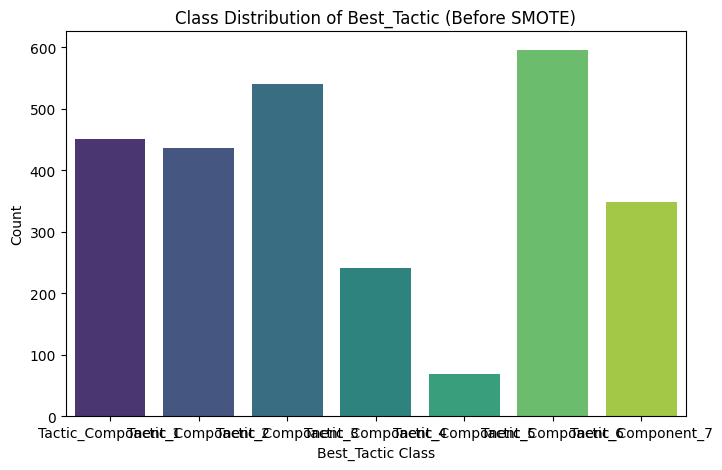


Class Distribution (Percentages):
Best_Tactic
Tactic_Component_1    16.81
Tactic_Component_2    16.25
Tactic_Component_3    20.16
Tactic_Component_4     9.02
Tactic_Component_5     2.57
Tactic_Component_6    22.21
Tactic_Component_7    12.97
Name: count, dtype: float64


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Check raw distribution
class_counts = df_model["Best_Tactic"].value_counts().sort_index()
print("Class Distribution (Best_Tactic):")
print(class_counts)

# Convert to DataFrame for easier plotting
class_df = pd.DataFrame({
    "Class": class_counts.index,
    "Count": class_counts.values
})

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x="Class", y="Count", data=class_df, palette="viridis")
plt.title("Class Distribution of Best_Tactic (Before SMOTE)")
plt.xlabel("Best_Tactic Class")
plt.ylabel("Count")
plt.show()

# Relative percentages
percentages = (class_counts / class_counts.sum()) * 100
print("\nClass Distribution (Percentages):")
print(percentages.round(2))


**SMOTE VERSION**

In [87]:
import joblib
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# =====================
# Apply SMOTE
# =====================
print("\n=== Apply SMOTE Oversampling ===")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Show class distribution before/after SMOTE
print("Before SMOTE:", pd.Series(y_train).value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_smote).value_counts().to_dict())

# =====================
# Refit Models with SMOTE
# =====================
final_models_smote = {}

for name, res in best_results.items():
    params = res["best_params"]

    if name == "RandomForest":
        model = RandomForestClassifier(**params, random_state=42)
        model.fit(X_train_smote, y_train_smote)

    elif name == "GradientBoost":
        model = GradientBoostingClassifier(**params, random_state=42)
        model.fit(X_train_smote, y_train_smote)

    elif name == "XGBoost":
        model = XGBClassifier(**params, random_state=42, eval_metric="mlogloss", n_jobs=-1)
        model.fit(X_train_smote, y_train_smote)

    elif name == "NeuralNet":
        model = MLPClassifier(**params, max_iter=500, random_state=42)
        model.fit(X_train_smote, y_train_smote)  # if scaled, scale X_train_smote first

    # Save model
    filename = f"{name.lower()}_smote.pkl"
    joblib.dump(model, filename)
    final_models_smote[name] = model
    print(f"✅ {name} (SMOTE) saved as {filename}")

# =====================
# Reload + Evaluate
# =====================
for name, model in final_models_smote.items():
    loaded = joblib.load(f"{name.lower()}_smote.pkl")
    y_pred = loaded.predict(X_test_scaled if name == "NeuralNet" else X_test)

    print(f"\n=== {name} Evaluation (SMOTE) ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
    print(classification_report(y_test, y_pred))



=== Apply SMOTE Oversampling ===
Before SMOTE: {5: 447, 2: 406, 0: 338, 1: 327, 6: 261, 3: 181, 4: 52}
After SMOTE: {3: 447, 1: 447, 5: 447, 6: 447, 2: 447, 0: 447, 4: 447}
✅ RandomForest (SMOTE) saved as randomforest_smote.pkl
✅ GradientBoost (SMOTE) saved as gradientboost_smote.pkl
✅ XGBoost (SMOTE) saved as xgboost_smote.pkl
✅ NeuralNet (SMOTE) saved as neuralnet_smote.pkl

=== RandomForest Evaluation (SMOTE) ===
Accuracy: 0.6736214605067065
Macro F1: 0.6183566814078786
              precision    recall  f1-score   support

           0       0.77      0.44      0.56       113
           1       0.77      0.82      0.79       109
           2       0.58      0.67      0.63       135
           3       0.60      0.79      0.68        61
           4       0.14      0.24      0.18        17
           5       0.73      0.69      0.71       149
           6       0.80      0.77      0.78        87

    accuracy                           0.67       671
   macro avg       0.63      0.63

c:\Users\Acer\cp_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [88]:
# ============================
# Support Vector Machine (SVM) Classifier with Explicit Scaling + Save/Load
# ============================

import os
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# =====================
# Features and Labels
# =====================
X = df_model.drop(columns=[
    "Best_Tactic", 'Match_ID', "Player_ID", "Manager_ID", 'Year', 'Date',
    'Tactic_Component_1','Tactic_Component_2','Tactic_Component_3',
    'Tactic_Component_4','Tactic_Component_5','Tactic_Component_6','Tactic_Component_7', 'Impact_Score'
])
le = LabelEncoder()
y = le.fit_transform(df_model["Best_Tactic"])

numeric_features = ['Passing', 'Shooting', 'Creativity', 'Dribbling', 'Defense']

# =====================
# Train/Test Split
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# =====================
# Column Transformer: scale only numeric columns
# =====================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# =====================
# Save/Load Path
# =====================
model_path = "svm_best_model.pkl"

if os.path.exists(model_path):
    # Load existing model
    best_svm = joblib.load(model_path)
    print("🔄 Loaded saved SVM model.")
else:
    # Define SVM and parameter grid
    svm = SVC(class_weight='balanced')
    param_grid = {
        'C': [0.1, 1, 10],                  # regularization
        'gamma': ['scale', 0.01, 0.1, 1],   # kernel coefficient
        'kernel': ['rbf', 'linear']         # kernels to test
    }

    # Grid search with Macro-F1 scoring
    grid_svm = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        scoring='f1_macro',   # main metric
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Train model
    grid_svm.fit(X_train_scaled, y_train)

    # Get best model
    best_svm = grid_svm.best_estimator_
    print("✅ Training complete. Best parameters:", grid_svm.best_params_)

    # Save the best model
    joblib.dump(best_svm, model_path)
    print(f"💾 Model saved to {model_path}")

# =====================
# Evaluation
# =====================
y_pred_svm = best_svm.predict(X_test_scaled)

print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm, digits=3))

print("Confusion Matrix (SVM):")
print(confusion_matrix(y_test, y_pred_svm))

# Macro-F1 Score
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')
print("Macro-F1 Score (SVM):", svm_f1)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Training complete. Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
💾 Model saved to svm_best_model.pkl
Classification Report (SVM):
              precision    recall  f1-score   support

           0      0.681     0.566     0.618       113
           1      0.781     0.817     0.798       109
           2      0.606     0.593     0.599       135
           3      0.529     0.738     0.616        61
           4      0.237     0.529     0.327        17
           5      0.821     0.678     0.743       149
           6      0.800     0.782     0.791        87

    accuracy                          0.680       671
   macro avg      0.636     0.672     0.642       671
weighted avg      0.704     0.680     0.686       671

Confusion Matrix (SVM):
[[ 64  10  21  10   0   1   7]
 [  5  89   1   4   0   3   7]
 [ 15   1  80  13  12  12   2]
 [  4   0   5  45   5   1   1]
 [  0   0   4   1   9   3   0]
 [  0   7  21 

In [89]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

comparison = []

# =====================
# Add SVM (Normal) to final_models
# =====================
final_models["SVM"] = best_svm   # best_svm already trained on X_train_scaled

# =====================
# Normal models (with SVM included)
# =====================
for name, model in final_models.items():
    # NeuralNet + SVM need scaled features
    if name in ["NeuralNet", "SVM"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    comparison.append({
        "Model": name,
        "Type": "Normal",
        "Accuracy": round(acc, 4),
        "Macro F1": round(macro_f1, 4)
    })

# =====================
# SVM with SMOTE
# =====================
# Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train a new SVM on SMOTE data (using best params from grid search if you want consistency)
svm_smote = SVC(
    class_weight='balanced',
    C=best_svm.get_params()['C'],
    gamma=best_svm.get_params()['gamma'],
    kernel=best_svm.get_params()['kernel']
)
svm_smote.fit(X_train_smote, y_train_smote)

# Save into final_models_smote
final_models_smote["SVM"] = svm_smote

# =====================
# SMOTE models (with SVM added)
# =====================
for name, model in final_models_smote.items():
    if name == "NeuralNet" or name == "SVM":
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    comparison.append({
        "Model": name,
        "Type": "SMOTE",
        "Accuracy": round(acc, 4),
        "Macro F1": round(macro_f1, 4)
    })

# =====================
# Create DataFrame for comparison
# =====================
df_comparison = pd.DataFrame(comparison)
df_comparison = df_comparison.sort_values(by=["Macro F1", "Accuracy"], ascending=False)

print("\n=== Final Model Comparison (Normal vs SMOTE) ===")
print(df_comparison.to_string(index=False))


c:\Users\Acer\cp_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



=== Final Model Comparison (Normal vs SMOTE) ===
        Model   Type  Accuracy  Macro F1
GradientBoost Normal    0.6811    0.6513
      XGBoost Normal    0.6870    0.6485
          SVM Normal    0.6796    0.6418
          SVM  SMOTE    0.6870    0.6371
 RandomForest Normal    0.6826    0.6318
    NeuralNet Normal    0.6721    0.6303
      XGBoost  SMOTE    0.6781    0.6299
 RandomForest  SMOTE    0.6736    0.6184
GradientBoost  SMOTE    0.6677    0.6175
    NeuralNet  SMOTE    0.3279    0.2772
